## **Bank Customer Churn Prediction**

#### **Perkenalan**

Nama: Christopher Kornelius Santoso

Batch: HCK-018

Proyek:

- --

#### **Problem Statement**

1. Rata-rata credit score menurut negara?
2. Jumlah total active member menurut negara?
3. Rata-rata salary yang diterima oleh customer berdasarkan negara?
4. Rata-rata salary income yang diterima menurut gender di setiap negara?
5. Produk number yang paling sering digunakan?

- --

#### **Import Library**

In [69]:
#library untuk manipulasi dataset dan memanggil dataset
import pandas as pd
import numpy as np

#library untuk visualisasi
import seaborn.objects as so
import matplotlib.pyplot as plt
import seaborn as sns

#library untuk feature engineering
from scipy.stats import kendalltau, spearmanr, chi2_contingency
from sklearn.model_selection import train_test_split
from feature_engine.outliers import Winsorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTENC
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

#library untuk model saving
import pickle
import json

- --

#### **Data Loading**

In [70]:
#Memuat dataset yang digunakan
data_bank_customer = pd.read_csv('Bank_Customer_Churn_Prediction.csv')
data_bank_customer.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


**Penjelasan Kolom:**
1. **customer_id**: id kustomer bank.
2. **credit_score**: skor kredit kustomer.
3. **country**: negara asal kustomer.
4. **gender**: jenis kelamin kustomer.
5. **age**: usia kustomer.
6. **tenure**: sisa waktu berlaku kartu kredit kustomer.
7. **balance**: saldo dari ksutomer.
8. **products_number**: jenis produk yang digunakan kustomer di bank tersebut.
9. **credit_card**: apakah kustomer memiliki kartu kredit atau tidak (1=punya, 0=tidak punya).
10. **active_member**: apakah kustomer member aktif di bank tersebut (1=aktif, 0=tidak aktif).
11. **estimated_salary**: gaji per tahun yang diterima kustomer.
12. **churn**: sebagai target dimana 1 untuk kustomer meninggalkan bank, 0 kustomer loyal terhadap bank.

In [71]:
#memuat informasi dataset
data_bank_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


Dari dataset di atas kita mendapatkan 2 kolom yang memiliki data type object yaitu `country` dan `gender`, selain itu ukuran dataset yang akan digunakan pada proses klasifikasi kali ini adalah 10000 rows x 12 kolom.

**Target** untuk model klasifikasi ini adalah church, untuk mengetahui tingkat churn customer berdasarkan dengan parameter yang tersedia.

- --

#### **Exploratory Data Analysis**

Sebelum melakukan proses exploratory, kita perlu untuk melakukan copy dataset dengan tujuan ketika terjadi perubahan pada dataset hal ini tidak akan merubah dataset original sehingga ketika kita ingin menggunakan dataset original kita masih bisa memakainya tanpa ada masalah.

In [72]:
#membuat copy dataset
data_bank_customer_eda = data_bank_customer.copy()
data_bank_customer_eda.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


##### **Rata-rata Credit Score Berdasarkan Negara**

In [73]:
#Melakukan groupby berdasarkan negara terhadap credit_score
credit_country = data_bank_customer_eda.groupby(['country'])['credit_score'].mean().sort_values(ascending=False).reset_index()
credit_country

,country,credit_score
0,Germany,651.453567
1,Spain,651.333872
2,France,649.668329


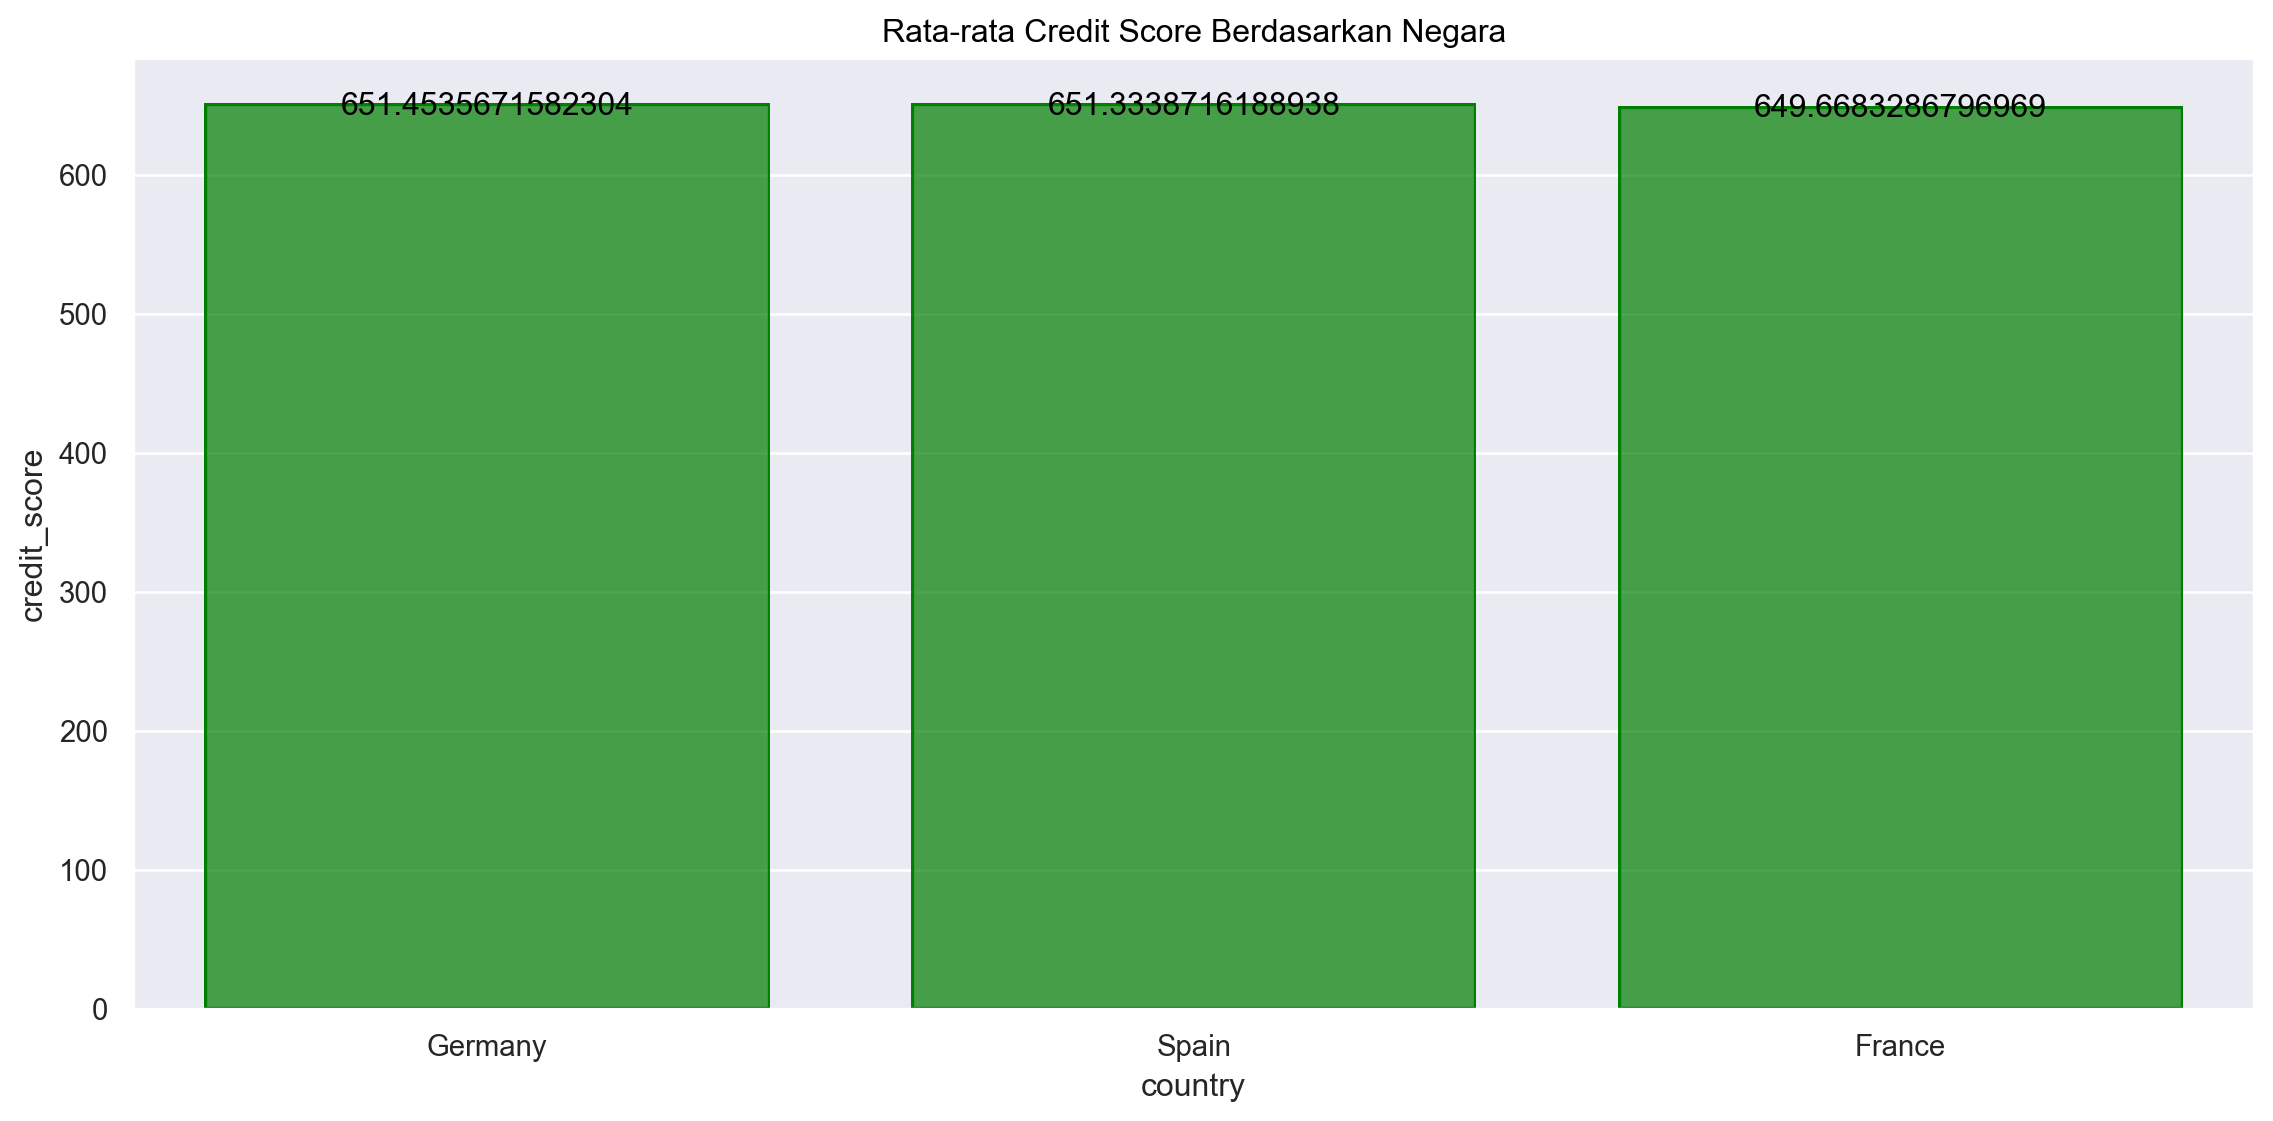

In [74]:
#Membuat visualisasi rata-rata credit score berdasarkan negara
visualize_credit = (
    so.Plot(credit_country, x="country", y="credit_score", text="credit_score").layout(size=(12,6))
    .add(so.Bar(color='green'))
    .add(so.Text(color="black", halign="center"))
)
visualize_credit.label(title="Rata-rata Credit Score Berdasarkan Negara")

Dari sini, kita mendapatkan bahwa Germany dan Spain memiliki rata-rata credit score dari setiap customer yang cukup tinggi dan hampir sama yaitu 651. Sementara France berada di belakang dengan selisih sedikit yaitu 649.

Hal ini menunjukkan bahwa customer credit card dari masing-masing negara sehat dan juga rutin melakukan pembayaran dan juga pembelian dengan menggunakan credit card.

##### **Jumlah Active Member menurut Negara**

In [75]:
#Melakukan groupby berdasarkan negara terhadap active_member
member_country = data_bank_customer_eda.groupby(['country'])['active_member'].value_counts().reset_index()
member_country

,country,active_member,count
0,France,1,2591
1,France,0,2423
2,Germany,0,1261
3,Germany,1,1248
4,Spain,1,1312
5,Spain,0,1165


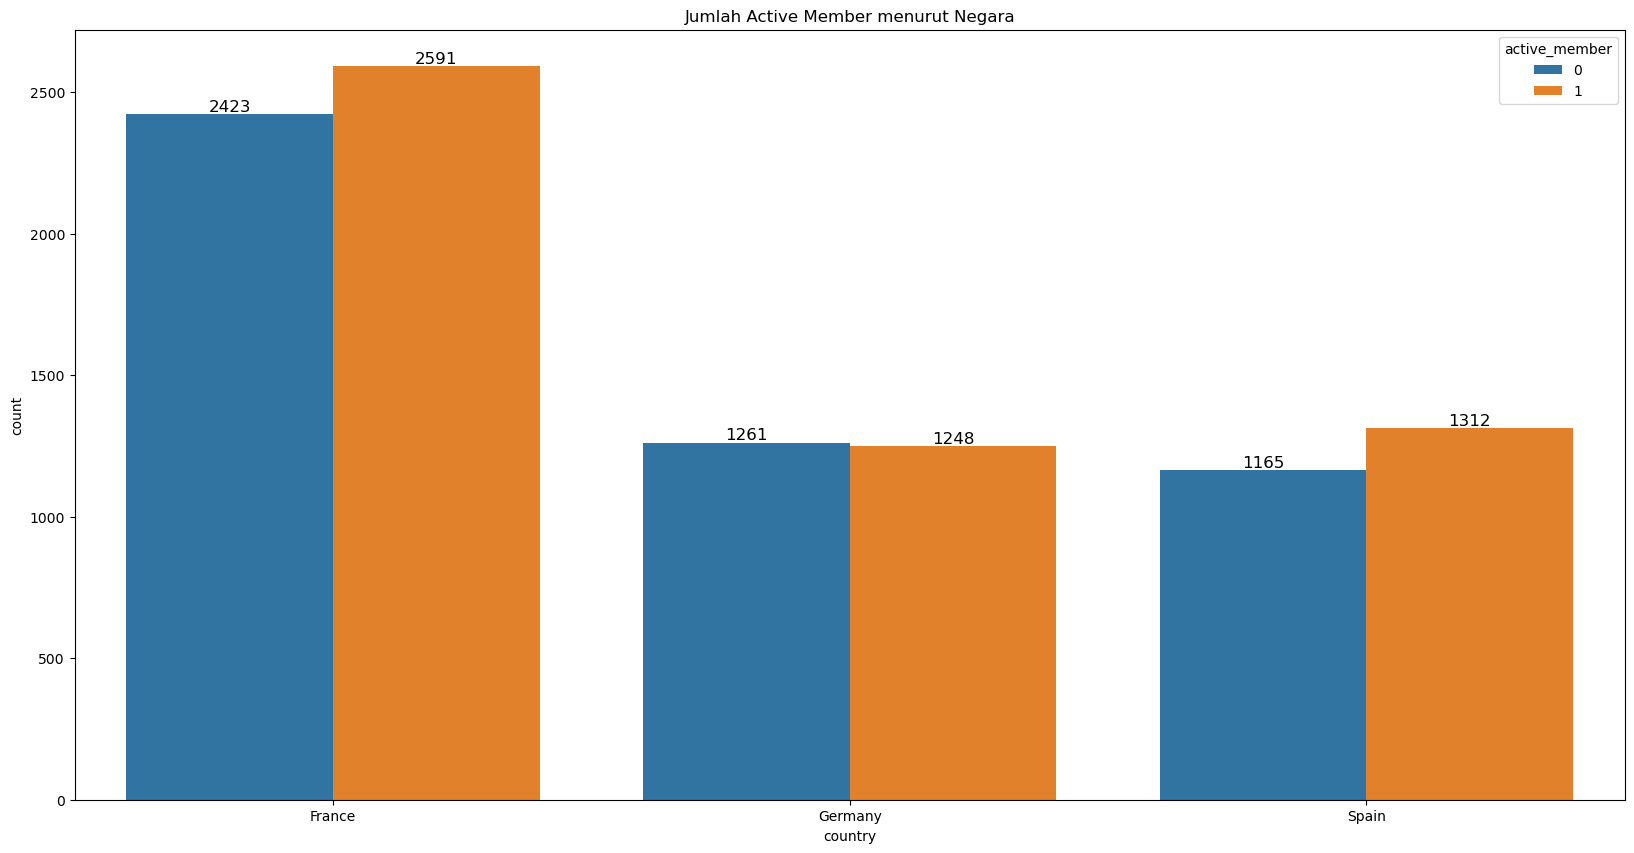

In [76]:
# Melakukan visualisasi berdasarkan negara dan active member
fig, ax = plt.subplots(figsize=(20, 10))

sns.barplot(member_country, x="country", y="count", hue="active_member")
# Menambahkan label ke bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=12)

plt.title('Jumlah Active Member menurut Negara')
plt.show()

Berdasarkan visualisasi data di atas kita mendapatkan bahwa, mayoritas jumlah customer baik dari aktif dan tidak berasal dari negara France (Prancis), diikuti oleh Jerman (Germany), dan terakhir Spain (Spanyol). Dengan jumlah customer terpusat pada Prancis, maka bisa diasumsikan bahwa pusat bank atau setidaknya bank tersebut berada di wilayah Prancis.

Sementara berdasarkan jenis active member, dimana jumlah customer dari bank tersebut secara jumlah mayoritas bukan customer atau anggota aktif di bank tersebut daripada member yang aktif. Disini bank perlu meningkatkan marketing atau menarik dengan promo dan lain-lain sehingga dapat menarik minat customer untuk menjadi member aktif di bank tersebut.

##### **Rata-rata Salary berdasarkan Negara**

In [77]:
#Melakukan groupby berdasarkan negara terhadap estimated salary
salary_country = data_bank_customer_eda.groupby(['country'])['estimated_salary'].mean().sort_values().reset_index()
salary_country

,country,estimated_salary
0,Spain,99440.572281
1,France,99899.180814
2,Germany,101113.435102


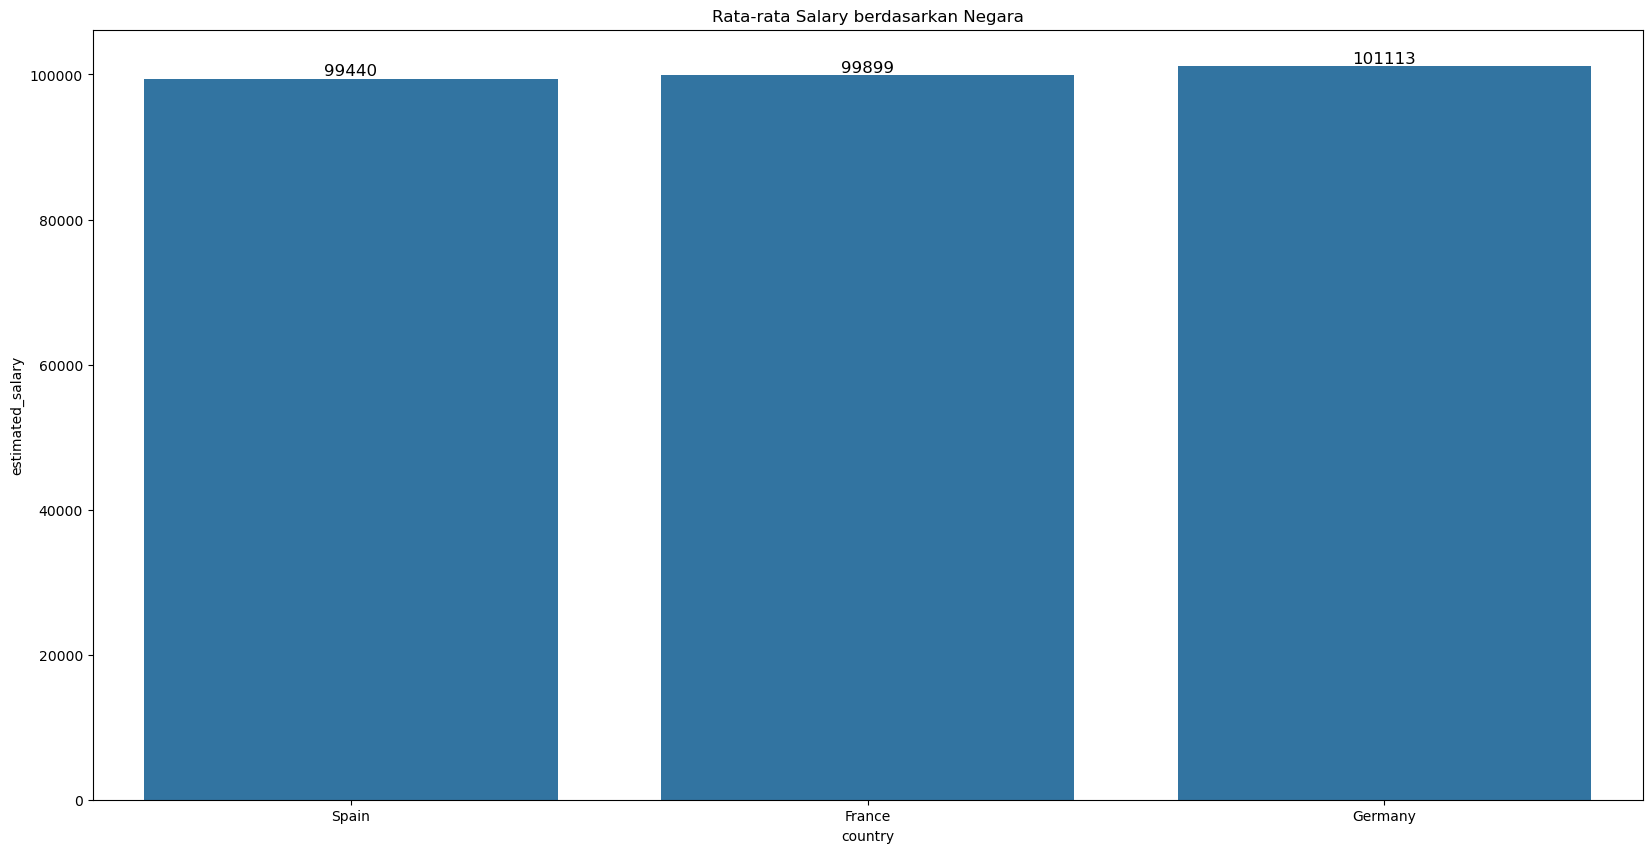

In [78]:
#Menampilkan visualisasi terhadap salary berdasarkan country
fig, ax = plt.subplots(figsize=(20, 10))

sns.barplot(salary_country, x="country", y="estimated_salary")
# Menambahkan label ke bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=12)

plt.title('Rata-rata Salary berdasarkan Negara')
plt.show()

Berdasarkan data di atas, kita mendapatkan bahwa Germany (Jerman) memiliki rata-rata salary paling tinggi di antara negara lainnya. Walaupun selisih antara negara Spain (Spanyol) dan France (Prancis) tidak terlalu jauh.

Disini salary bisa mempengaruhi tingkat churn dari bank. Dimana salary dapat mempengaruhi balance dari seorang customer, dengan semakin tinggi balance dari customer maka kemungkinan customer untuk meninggalkan bank akan semakin kecil.

##### **Rata-rata Income yang diterima berdasarkan Gender di setiap Negara**

In [79]:
#Melakukan group by berdasarkan country dan gender terhadap estimated_salary
gender_income_country = data_bank_customer_eda.groupby(['country','gender'])['estimated_salary'].mean().reset_index()
gender_income_country

,country,gender,estimated_salary
0,France,Female,99564.252755
1,France,Male,100174.252495
2,Germany,Female,102446.424124
3,Germany,Male,99905.033959
4,Spain,Female,100734.107475
5,Spain,Male,98425.687680


In [80]:
#Melakukan group by berdasarkan country dan gender terhadap estimated_salary
gender_active_country = data_bank_customer_eda.groupby(['country','gender'])['churn'].value_counts().reset_index()
gender_active_country

,country,gender,churn,count
0,France,Female,0,1801
1,France,Female,1,460
2,France,Male,0,2403
3,France,Male,1,350
4,Germany,Female,0,745
5,Germany,Female,1,448
6,Germany,Male,0,950
7,Germany,Male,1,366
8,Spain,Female,0,858
9,Spain,Female,1,231


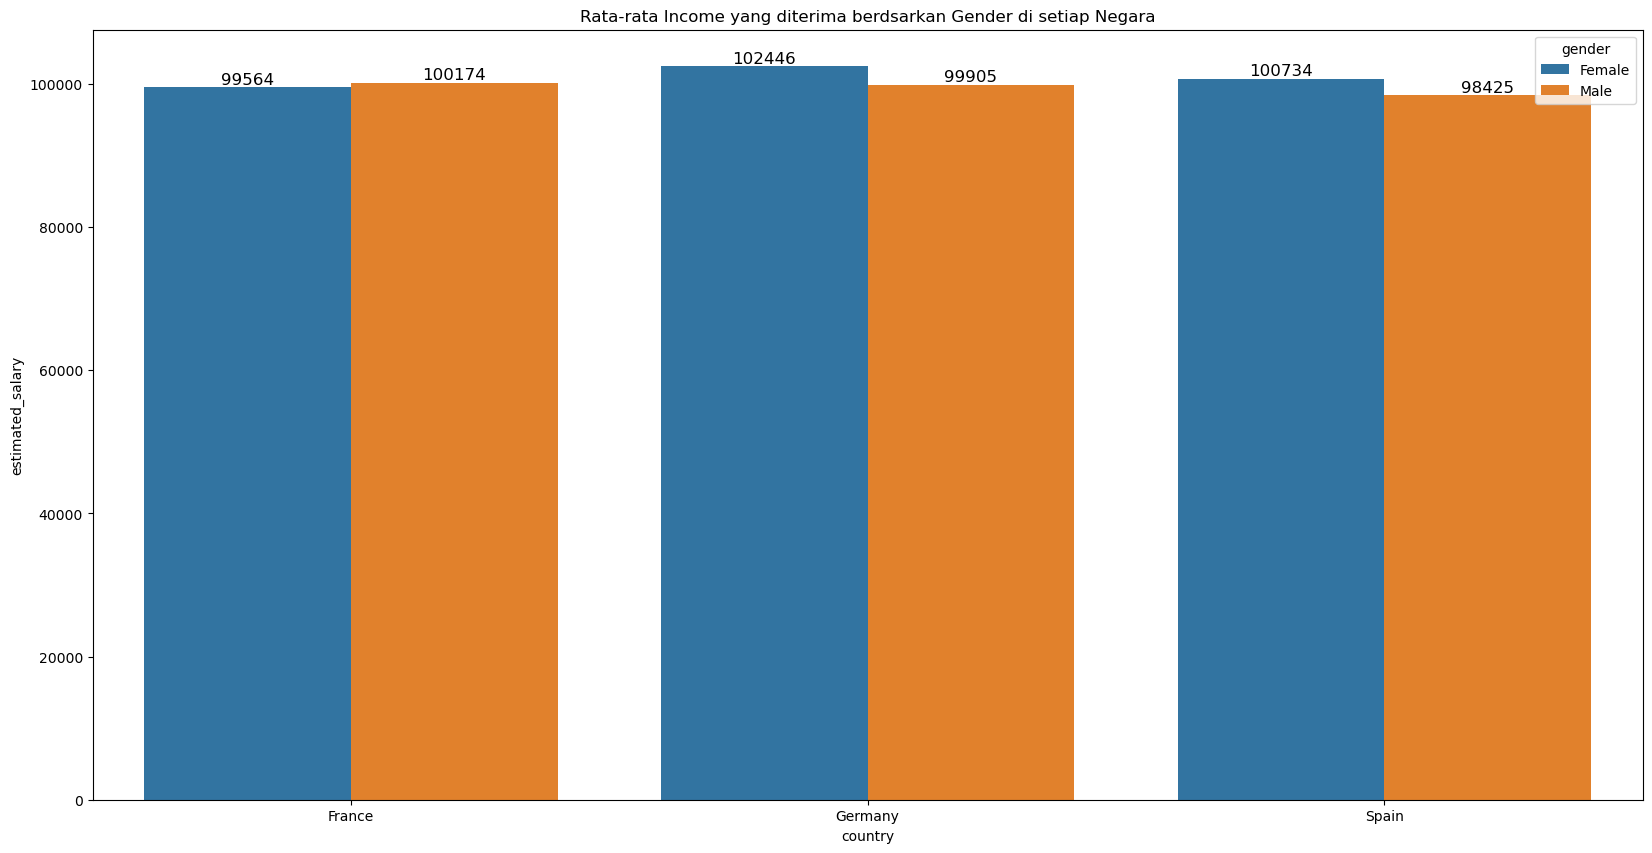

In [81]:
#Melakukan visualisasi berdasarkan country dan gender terhadap estimated salary
fig, ax = plt.subplots(figsize=(20, 10))

sns.barplot(gender_income_country, x="country", y="estimated_salary", hue="gender")
# Menambahkan label ke bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=12)

plt.title('Rata-rata Income yang diterima berdsarkan Gender di setiap Negara')
plt.show()

Berdasarkan grafik di atas, kita mendapatkan bahwa rata-rata salary yang diterima oleh wanita cukup bersaing dengan customer pria dimana jarak selisih salary yang diterima tidak jauh dengan selisih paling jauh adalah $3000.

Selain itu, hal ini menguatkan asumsi bahwa salary meningkatkan balance dan meningkatkan kemungkinan churn atau kembali ke bank tersebut daripada kebalikannya. 

##### **Produk number yang Paling Sering Digunakan**

In [82]:
#Melakukan group by berdasarkan country dan gender terhadap estimated_salary
product_gender = data_bank_customer_eda.groupby(['country'])['products_number'].value_counts().reset_index()
product_gender

,country,products_number,count
0,France,1,2514
1,France,2,2367
2,France,3,104
3,France,4,29
4,Germany,1,1349
5,Germany,2,1040
6,Germany,3,96
7,Germany,4,24
8,Spain,1,1221
9,Spain,2,1183


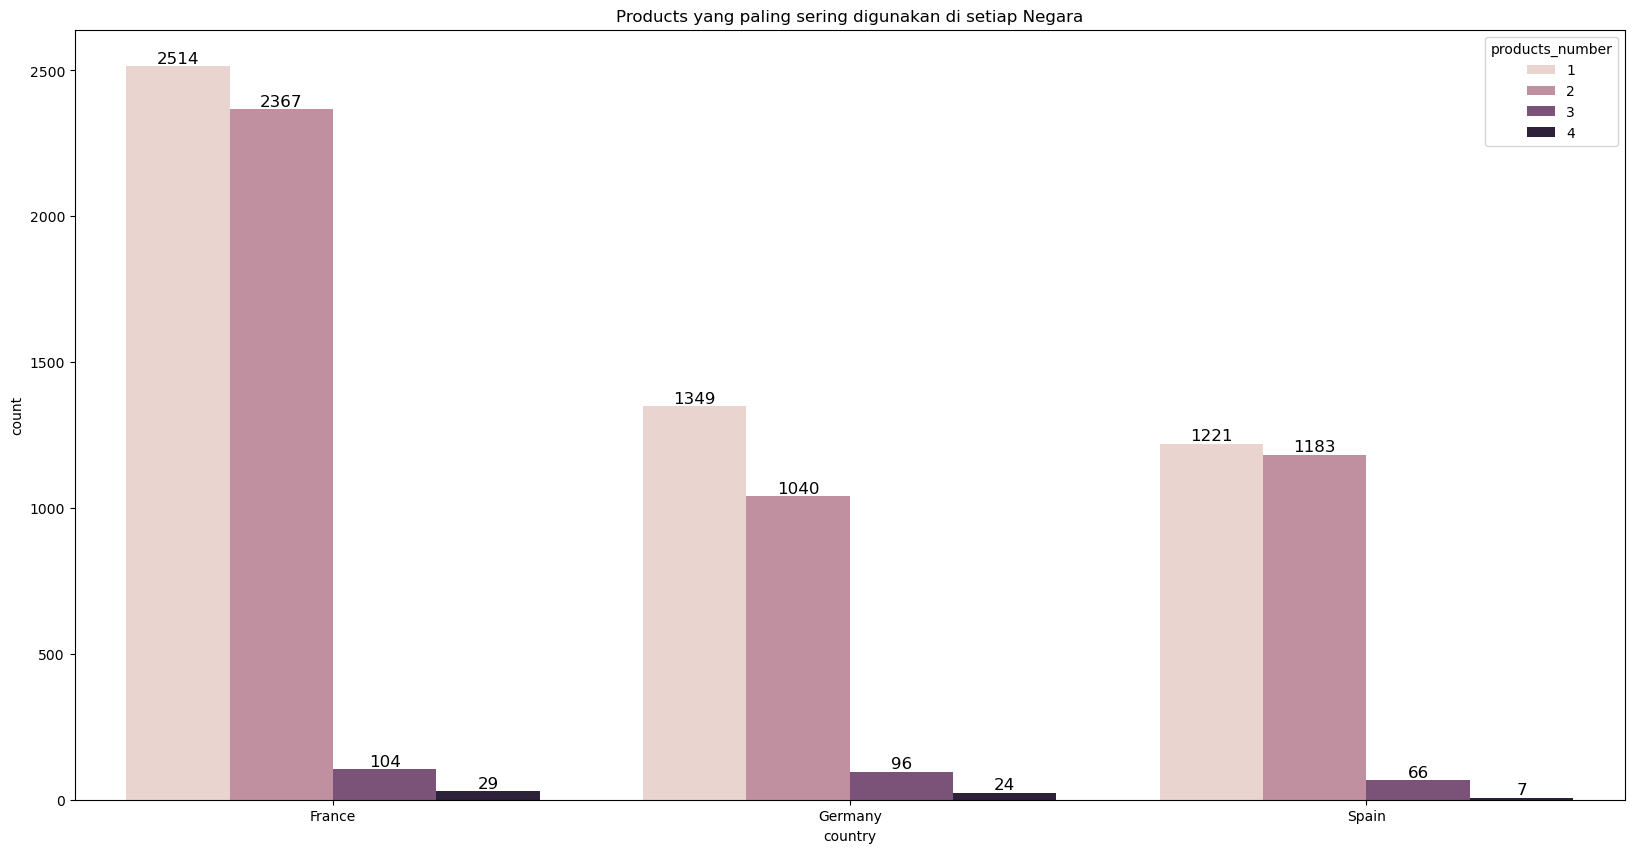

In [83]:
#Melakukan visualisasi berdasarkan country dan gender terhadap estimated salary
fig, ax = plt.subplots(figsize=(20, 10))

sns.barplot(product_gender, x="country", y="count", hue="products_number")
# Menambahkan label ke bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=12)

plt.title('Products yang paling sering digunakan di setiap Negara')
plt.show()

Berdasarkan data di atas kita mendapatkan bahwa produk yang paling sering digunakan adalah products number 1 diikuti oleh products number 2. Sementara products number 4 paling jarang digunakan.

Bisa diasumsikan bahwa products number 4 memberikan dampak yang tidak signifikan pada customer dalam kebutuhan sehari-hari, sehingga products number 4 membutuhkan perhatian lebih dengan cara dengan memberikan beberapa poin merits atau memberikan tambahan keuntungan dari penggunaan products number 4.

- --

#### **Feature Engineering**

Sebelum masuk ke dalam proses feature engineering, kita perlu untuk mengcopy dataset terlebih dahulu, tujuan dari mengcopy dataset ini seperti dijelaskan pada tahap sebelumnya adalah untuk mencegah perubahan pada dataset asli sehingga ketika kita ingin menggunakan dataset asli maka kita bisa langsung menggunakannya tanpa ada masalah.

In [84]:
data_bank_customer_fe = data_bank_customer.copy()
data_bank_customer_fe.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Setelah mengcopy dataset, kita dapat langsung mengecek kardinalitas data untuk membagi kolom-kolom dari dataset sesuai dengan tipe datanya apakah nominal, ordinal, atau numerikal.

##### **Mencari Kardinalitas Data**

In [85]:
#mengecek kardinalitas data
#Mengecek kardinalitas dataset.
def cardinality(df):
    col_name = []
    nunique = []
    unique_char = []

    for column in data_bank_customer_fe.columns:
        col_name.append(column)
        nunique.append(data_bank_customer_fe[column].nunique())
        unique_char.append(data_bank_customer_fe[column].unique())
    
    data_cardinality = pd.DataFrame({
        'Column Name':col_name,
        'Nunique': nunique,
        'Unique Char': unique_char
    })

    return data_cardinality

In [86]:
#Menampilkan kardinalitas dataset
pd.set_option('display.max_colwidth',None)
pd.set_option('display.max_rows', None)
cardinality(data_bank_customer_fe)

,Column Name,Nunique,Unique Char
0,customer_id,10000,"[15634602, 15647311, 15619304, 15701354, 15737888, 15574012, 15592531, 15656148, 15792365, 15592389, 15767821, 15737173, 15632264, 15691483, 15600882, 15643966, 15737452, 15788218, 15661507, 15568982, 15577657, 15597945, 15699309, 15725737, 15625047, 15738191, 15736816, 15700772, 15728693, 15656300, 15589475, 15706552, 15750181, 15659428, 15732963, 15794171, 15788448, 15729599, 15717426, 15585768, 15619360, 15738148, 15687946, 15755196, 15684171, 15754849, 15602280, 15771573, 15766205, 15771873, 15616550, 15768193, 15683553, 15702298, 15569590, 15760861, 15630053, 15647091, 15623944, 15804771, 15651280, 15773469, 15702014, 15751208, 15592461, 15789484, 15696061, 15641582, 15638424, 15755648, 15703793, 15620344, 15812518, 15779052, 15770811, 15780961, 15614049, 15662085, 15575185, 15803136, 15706021, 15663706, 15641732, 15701164, 15738751, 15805254, 15762418, 15625759, 15622897, 15767954, 15757535, 15731511, 15809248, 15640635, 15676966, 15699461, 15738721, 15693683, 15604348, 15633059, ...]"
1,credit_score,460,"[619, 608, 502, 699, 850, 645, 822, 376, 501, 684, 528, 497, 476, 549, 635, 616, 653, 587, 726, 732, 636, 510, 669, 846, 577, 756, 571, 574, 411, 591, 533, 553, 520, 722, 475, 490, 804, 582, 472, 465, 556, 834, 660, 776, 829, 637, 550, 698, 585, 788, 655, 601, 656, 725, 511, 614, 742, 687, 555, 603, 751, 581, 735, 661, 675, 738, 813, 657, 604, 519, 664, 678, 757, 416, 665, 777, 543, 506, 493, 652, 750, 729, 646, 647, 808, 524, 769, 730, 515, 773, 814, 710, 413, 623, 670, 622, 785, 605, 479, 685, ...]"
2,country,3,"[France, Spain, Germany]"
3,gender,2,"[Female, Male]"
4,age,70,"[42, 41, 39, 43, 44, 50, 29, 27, 31, 24, 34, 25, 35, 45, 58, 32, 38, 46, 36, 33, 40, 51, 61, 49, 37, 19, 66, 56, 26, 21, 55, 75, 22, 30, 28, 65, 48, 52, 57, 73, 47, 54, 72, 20, 67, 79, 62, 53, 80, 59, 68, 23, 60, 70, 63, 64, 18, 82, 69, 74, 71, 76, 77, 88, 85, 84, 78, 81, 92, 83]"
5,tenure,11,"[2, 1, 8, 7, 4, 6, 3, 10, 5, 9, 0]"
6,balance,6382,"[0.0, 83807.86, 159660.8, 125510.82, 113755.78, 115046.74, 142051.07, 134603.88, 102016.72, 143129.41, 132602.88, 136815.64, 141349.43, 59697.17, 85311.7, 110112.54, 134264.04, 145260.23, 76548.6, 70349.48, 122522.32, 117419.35, 131394.56, 155931.11, 109421.13, 112045.67, 137843.8, 103391.38, 103769.22, 116363.37, 146050.97, 125561.97, 98495.72, 125211.92, 127864.4, 75888.2, 40685.92, 136857.0, 152328.88, 56084.69, 78707.16, 109166.37, 169831.46, 101633.04, 123180.01, 150725.53, 98373.26, 133745.44, 163607.18, 157780.84, 178718.19, 77253.22, 122189.66, 96645.54, 90307.62, 121681.82, 81623.67, 118626.55, 176273.95, 102827.44, 97086.4, 82674.15, 107073.27, 88938.62, 99806.85, 150092.8, 92833.89, 90536.81, 108055.1, 100238.35, 106190.55, 154475.54, 132351.29, 167864.4, 107818.63, 185173.81, 129433.34, 120193.42, 126384.42, 152603.45, 148507.24, 101827.07, 130862.43, 122570.87, 124828.46, 144895.05, 63663.93, 133463.1, 213146.2, 129490.36, 137452.09, 125851.93, 40915.55, 113157.22, 138296.94, 106967.18, 120681.63, 127609.59, 97259.25, 123246.7, ...]"
7,products_number,4,"[1, 3, 2, 4]"
8,credit_card,2,"[1, 0]"
9,active_member,2,"[1, 0]"


Berdasarkan hasil kardinalitas data yang didapatkan, maka kita mendapatkan hasil kardinalitas sebagai berikut:

| Nama Kolom | Tipe Kardinalitas |
| ---------- | ----------------- |
| customer_id | Nominal |
| credit_score | Numerikal | 
| country | Nominal |
| gender | Nominal |
| age | Numerikal |
| tenure | Numerikal |
| balance | Numerikal |
| products_number | Nominal |
| credit_card | Ordinal |
| active_member | Ordinal |
| estimated_salary | Numerikal |


- --

##### **Split Train Test Data**

In [87]:
#Membagi dataset menjadi data train dan data test
#Melakukan pembagian dataset dengan melakukan drop kolom target
X = data_bank_customer_fe.drop(columns=['churn'], axis=1)
y = data_bank_customer_fe['churn']

# Membagi data test dan data train
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state=2024)

# Check the size
print(f'Train set : {X_train.shape}')
print(f'test set : {X_test.shape}')

Train set : (8000, 11)
test set : (2000, 11)


Dari pembagian data di atas maka kita mendapatkan komposisi data train dan data test sebagai berikut:
1. **Data Train:** 8000 rows x 11 columns
2. **Data Test:** 2000 rows x 11 columns

- --

##### **Outlier Handling**

**Pembagian Data Sesuai Kardinalitas**

In [88]:
nominal_col = data_bank_customer_fe[['customer_id','country','gender','products_number']]
numerikal_col = data_bank_customer_fe[['credit_score','age','tenure','balance','estimated_salary']]
ordinal_col = data_bank_customer_fe[['credit_card','active_member']]

nominal_colname = ['customer_id','country','gender','products_number']
numerikal_colname = ['credit_score','age','tenure','balance','estimated_salary']
ordinal_colname = ['credit_card','active_member']

Setelah selesai melakukan pembagian data sesuai kardinalitas, selanjutnya adalah melakukan outlier handling.

In [89]:
#Melakukan proses outlier detection
def outlier_detection(dataset):
    result = pd.DataFrame()
    col_name = []
    skew = []
    upper = []
    lower = []
    has_outliers = []
    outlier_types=[]
    outlier_handling = []

    #Memuat nama kolom
    for column in dataset.columns:
        col_name.append(column)
    
    #Mencari nilai skewness
        skewval = dataset[column].skew()
        skew.append(skewval)
    
    # Extreme Skew
        if skewval > 1 or skewval < -1:
            IQR = data_bank_customer_fe[column].quantile(0.75) - data_bank_customer_fe[column].quantile(0.25)
            lower_boundary = data_bank_customer_fe[column].quantile(0.25) - (IQR * 3)
            upper_boundary = data_bank_customer_fe[column].quantile(0.75) + (IQR * 3)
            outlier_types.append('Extreme')
            outlier_handling.append('IQR')

        # Middle skewed
        elif skewval >= 0.5 or skewval <= -0.5:
            IQR = data_bank_customer_fe[column].quantile(0.75) - data_bank_customer_fe[column].quantile(0.25)
            lower_boundary = data_bank_customer_fe[column].quantile(0.25) - (IQR * 1.5)
            upper_boundary = data_bank_customer_fe[column].quantile(0.75) + (IQR * 1.5)
            outlier_types.append('Medium')
            outlier_handling.append('Quantile')
        # Normal distribusi
        else:
            std = data_bank_customer_fe[column].std()
            lower_boundary = data_bank_customer_fe[column].mean() - (std * 3)
            upper_boundary = data_bank_customer_fe[column].mean() + (std * 3)
            outlier_types.append('Normal')
            outlier_handling.append('Gaussian')
        # AMenambahkan ke kolom upper dan lower
        upper.append(upper_boundary)
        lower.append(lower_boundary)
        
        # Chek apakah ada outlier
        outliers = (data_bank_customer_fe[column] < lower_boundary) | (data_bank_customer_fe[column] > upper_boundary)
        has_outliers.append(any(outliers))

    # Menambahkan data ke dataframe
    result['columns'] = col_name
    result['skewness'] = skew
    result['upper boundary'] = upper
    result['lower boundary'] = lower
    result['has outliers'] = has_outliers
    result['outlier type'] = outlier_types
    result['handling'] = outlier_handling

    return result

# Mengecek dataset numerical
outlier_data = outlier_detection(numerikal_col)
outlier_data

,columns,skewness,upper boundary,lower boundary,has outliers,outlier type,handling
0,credit_score,-0.071607,940.488696,360.568904,True,Normal,Gaussian
1,age,1.011320,80.000000,-4.000000,True,Extreme,IQR
2,tenure,0.010991,13.689323,-3.663723,False,Normal,Gaussian
3,balance,-0.141109,263678.104895,-110706.326319,False,Normal,Gaussian
4,estimated_salary,0.002085,272621.718334,-72441.238572,False,Normal,Gaussian


In [90]:
#Filter untuk distribusi extreme
have_outliers = outlier_data[(outlier_data['has outliers']==True)&(outlier_data['handling']=='Gaussian')]['columns'].tolist()

#winsor untuk normal distribusi
winsorizer_normal = Winsorizer(
    capping_method='gaussian',
    tail='both',
    fold=3,
    variables=have_outliers,
    missing_values='ignore'
)

X_train_capped = winsorizer_normal.fit_transform(X_train)
X_test_capped = winsorizer_normal.transform(X_test)

In [91]:
#Filter untuk distribusi extreme
have_outliers = outlier_data[(outlier_data['has outliers']==False)&(outlier_data['handling']=='Gaussian')]['columns'].tolist()

#winsor untuk normal distribusi
winsorizer_normal = Winsorizer(
    capping_method='gaussian',
    tail='both',
    fold=3,
    variables=have_outliers,
    missing_values='ignore'
)

X_train_capped = winsorizer_normal.fit_transform(X_train)
X_test_capped = winsorizer_normal.transform(X_test)

In [92]:
#Filter untuk distribusi extreme
have_outliers = outlier_data[(outlier_data['has outliers']==True)&(outlier_data['handling']=='IQR')]['columns'].tolist()

#winsor untuk normal distribusi
winsorizer_normal = Winsorizer(
    capping_method='iqr',
    tail='both',
    fold=3,
    variables=have_outliers,
    missing_values='ignore'
)

X_train_capped = winsorizer_normal.fit_transform(X_train)
X_test_capped = winsorizer_normal.transform(X_test)

In [93]:
#Fungsi untuk menampilkan boxplot dari outlier sebelum dan sesudah
def diagnostic_plots(df, variable):
    # ukuran diagram
    plt.figure(figsize=(16, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

customer_id - Before Capping


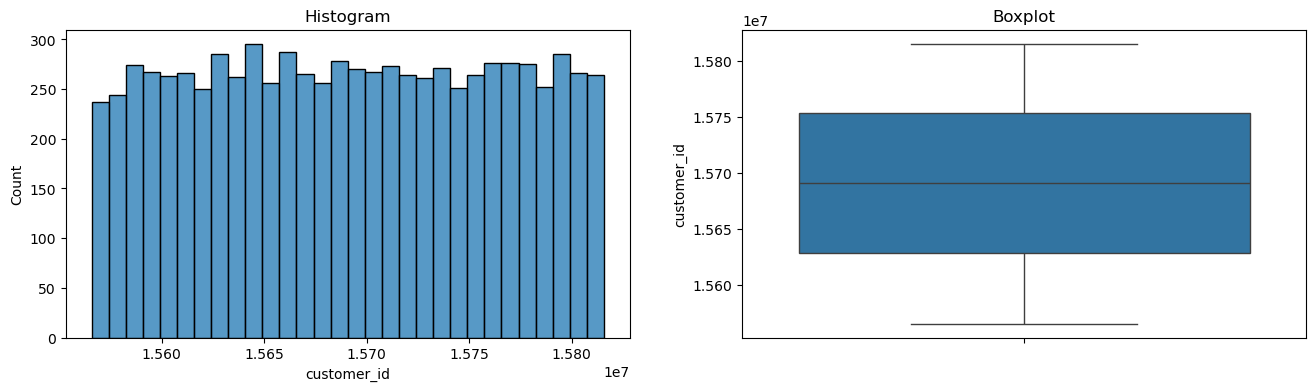


customer_id - After Capping


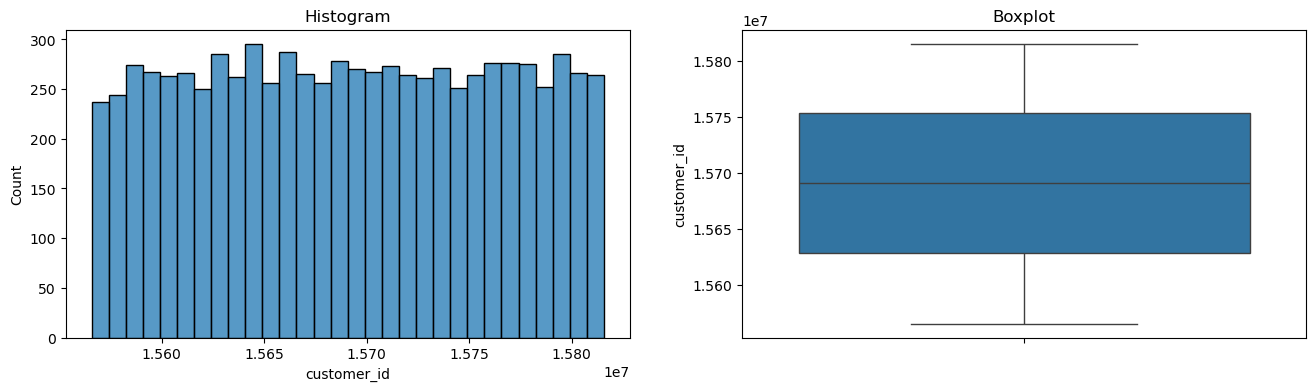

credit_score - Before Capping


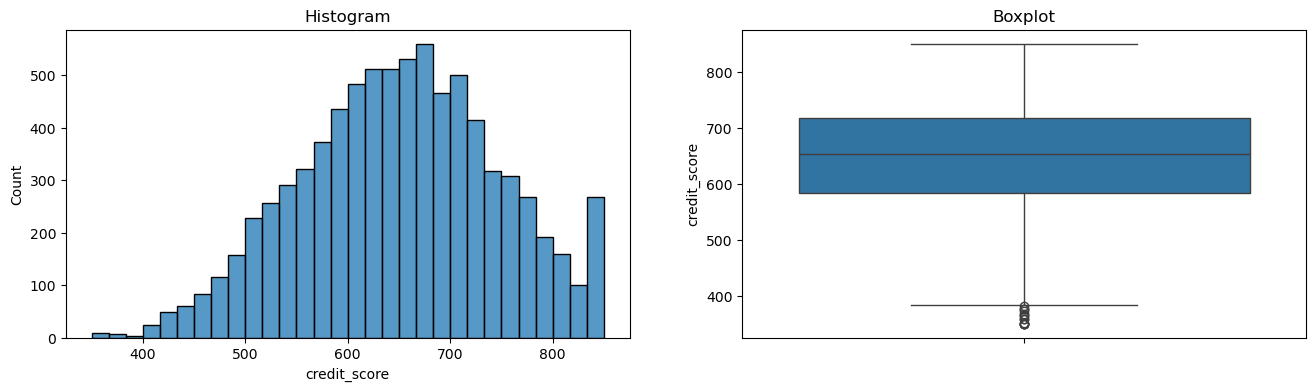


credit_score - After Capping


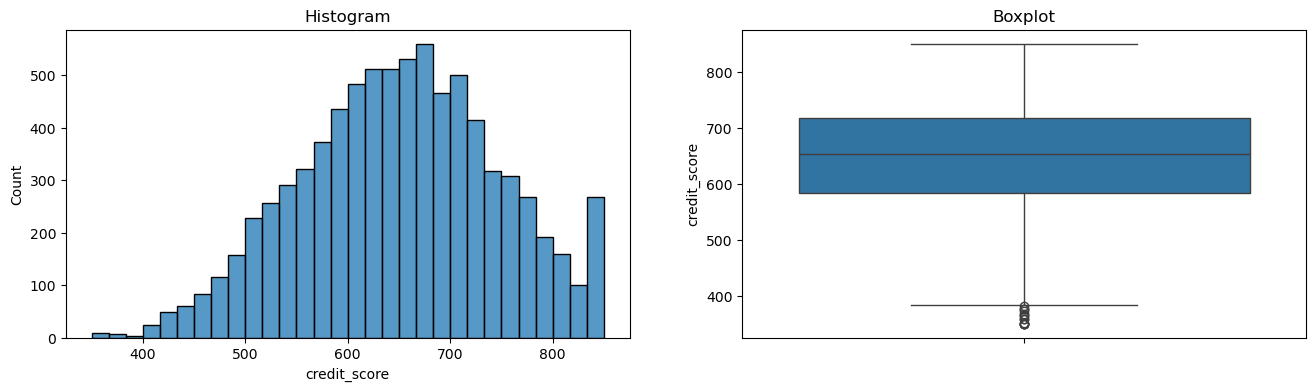

country - Before Capping


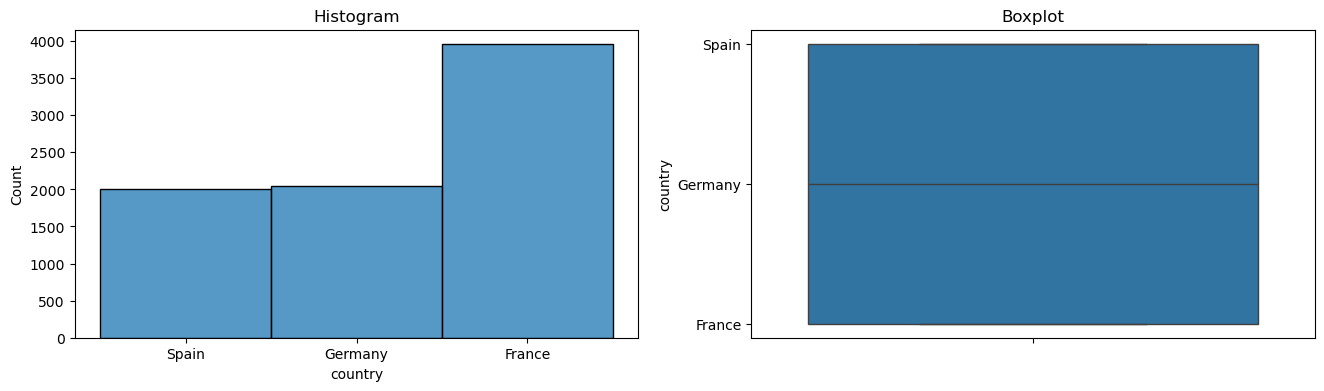


country - After Capping


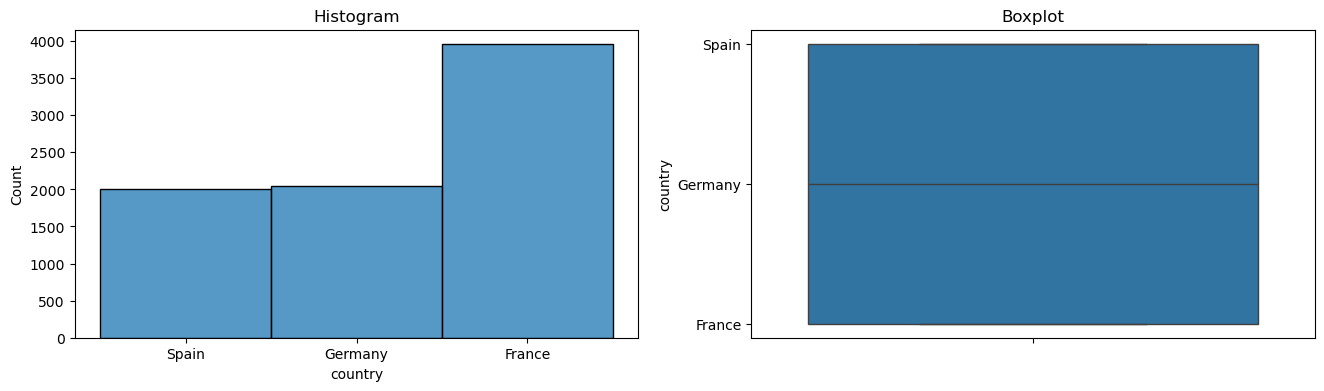

gender - Before Capping


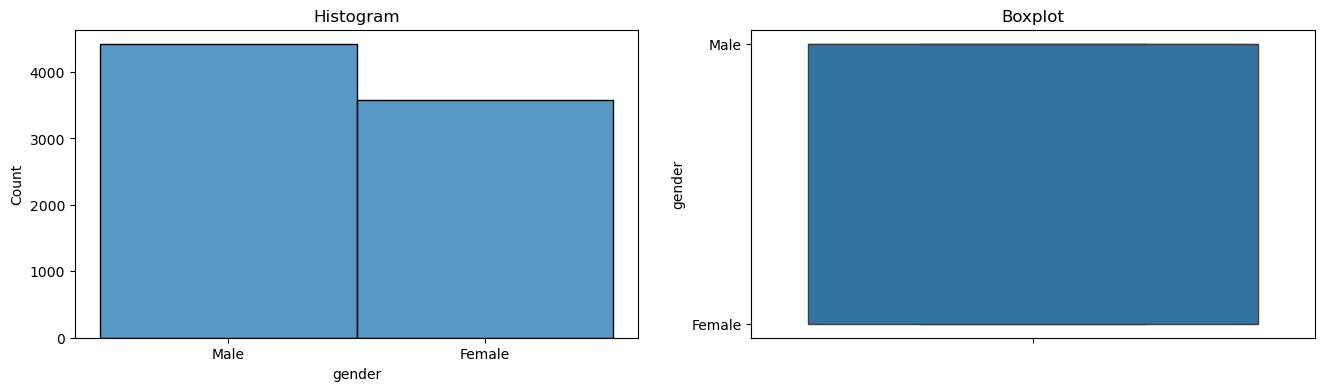


gender - After Capping


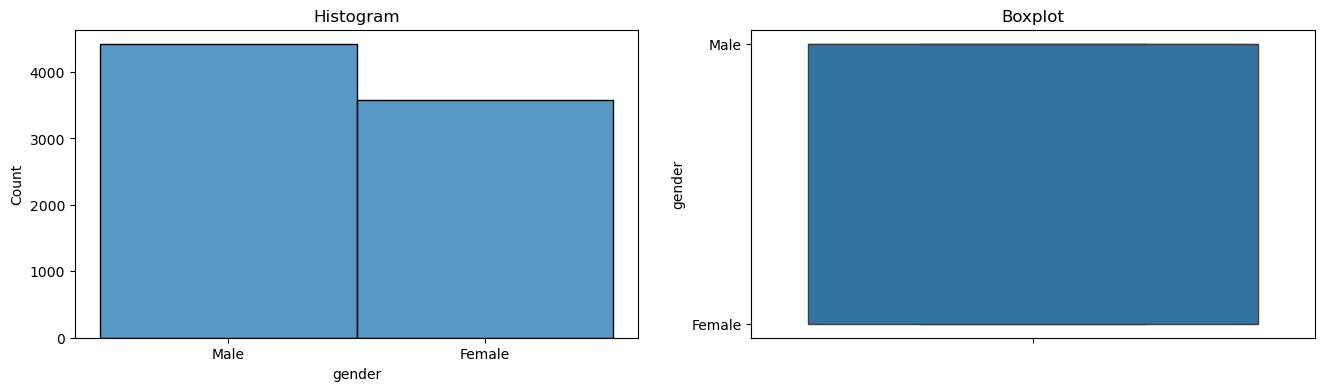

age - Before Capping


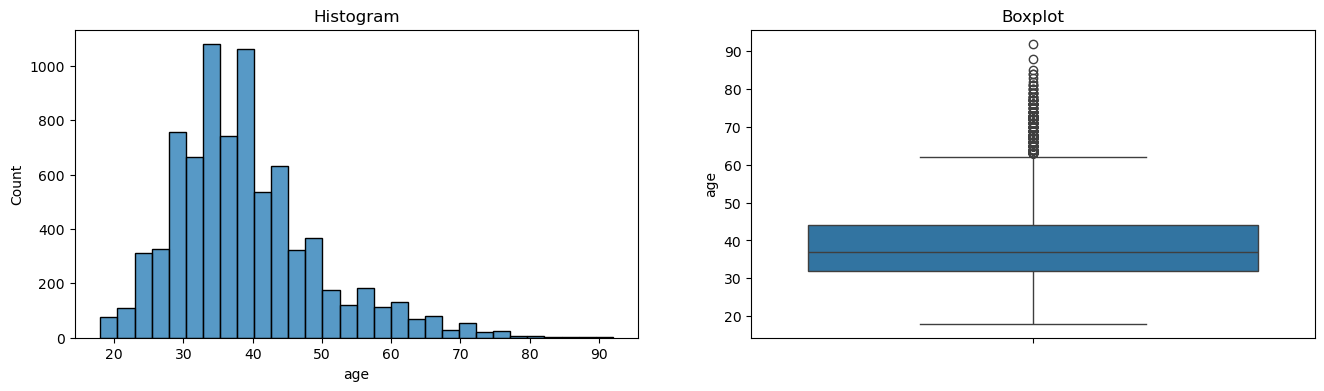


age - After Capping


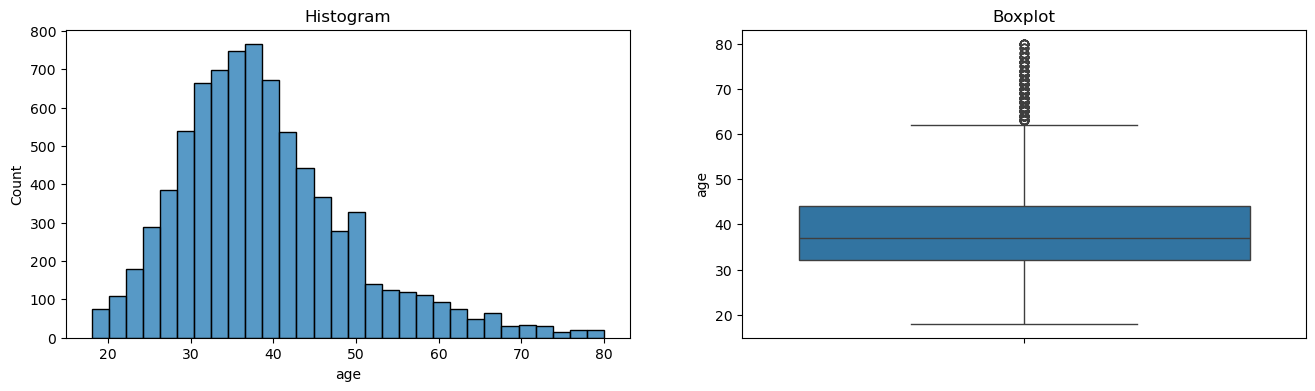

tenure - Before Capping


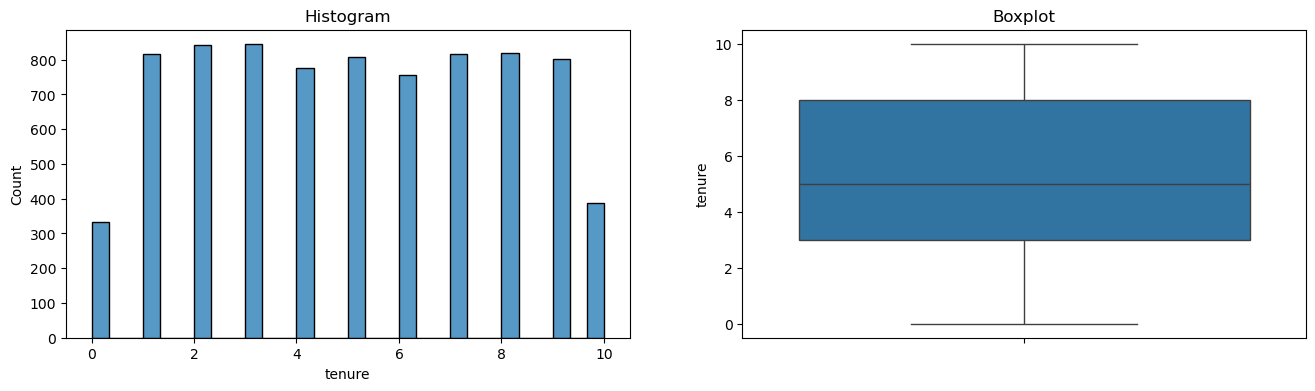


tenure - After Capping


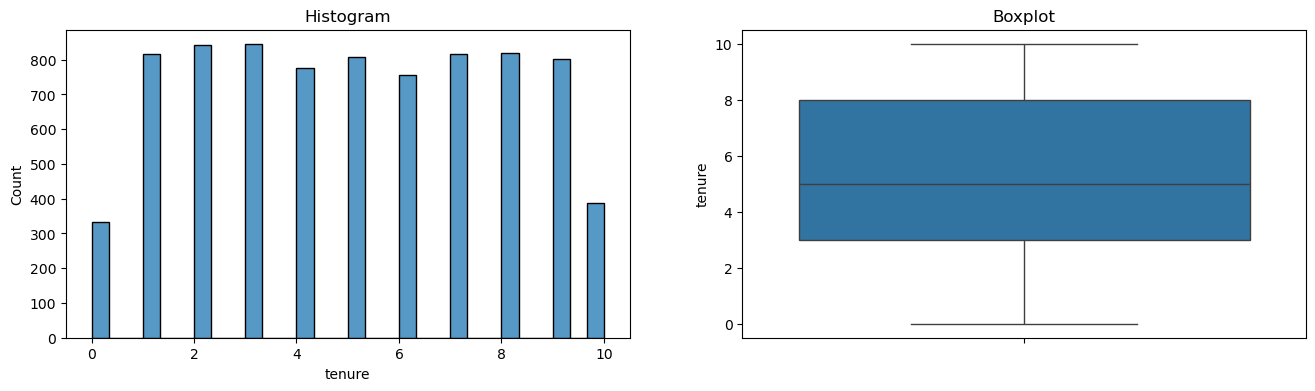

balance - Before Capping


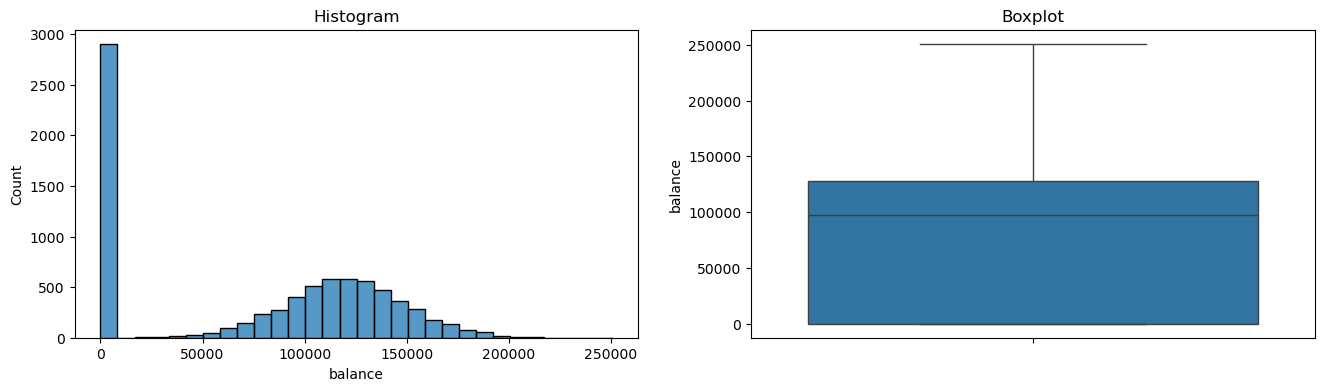


balance - After Capping


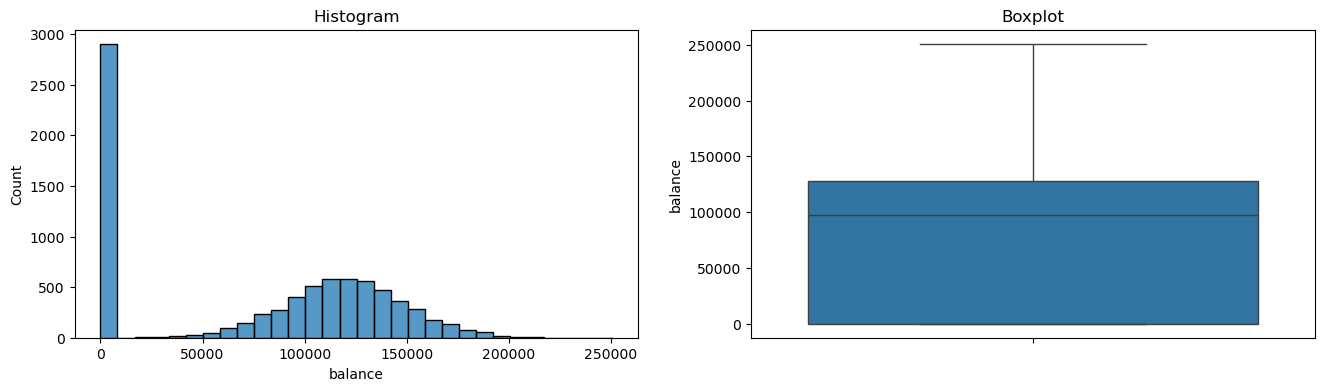

products_number - Before Capping


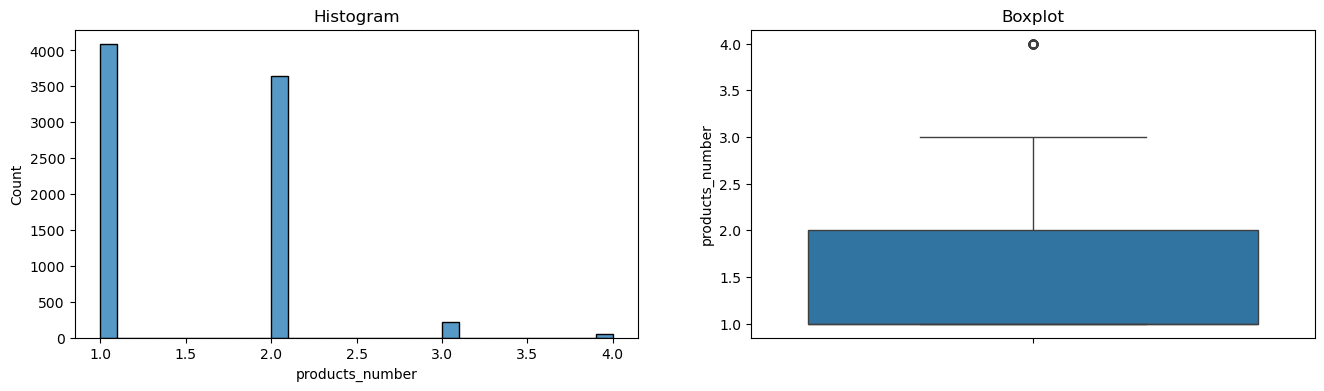


products_number - After Capping


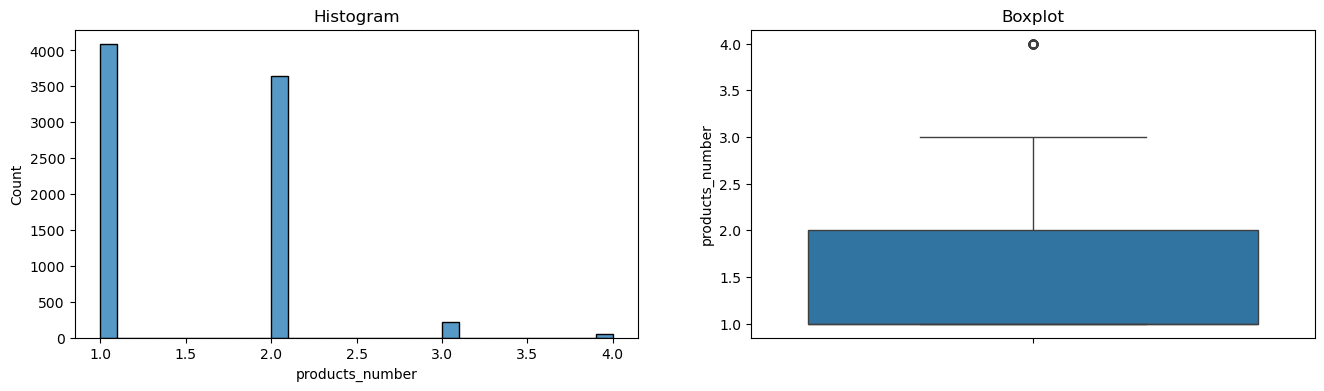

credit_card - Before Capping


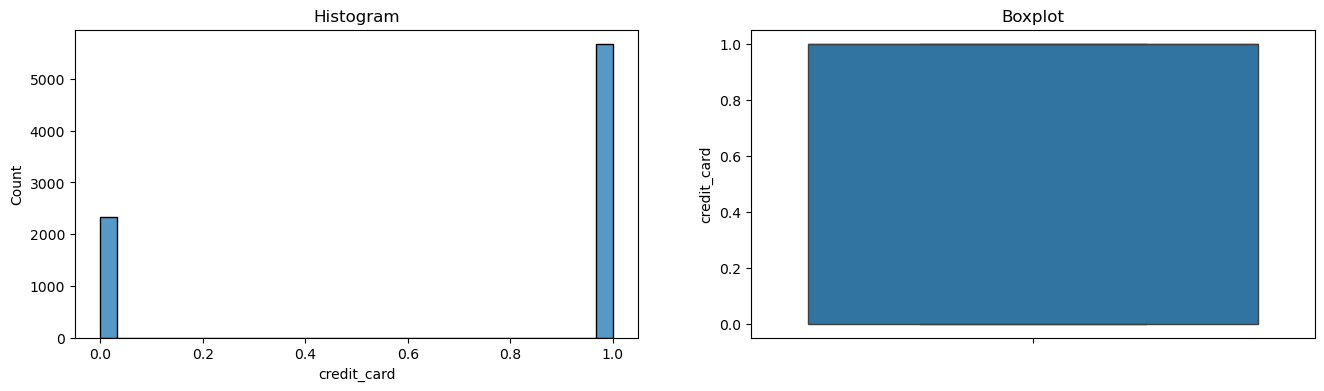


credit_card - After Capping


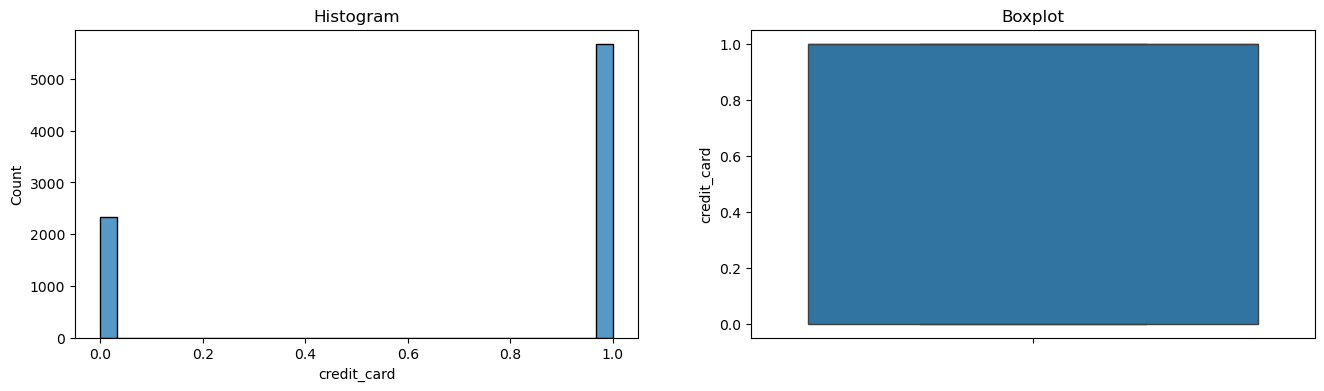

active_member - Before Capping


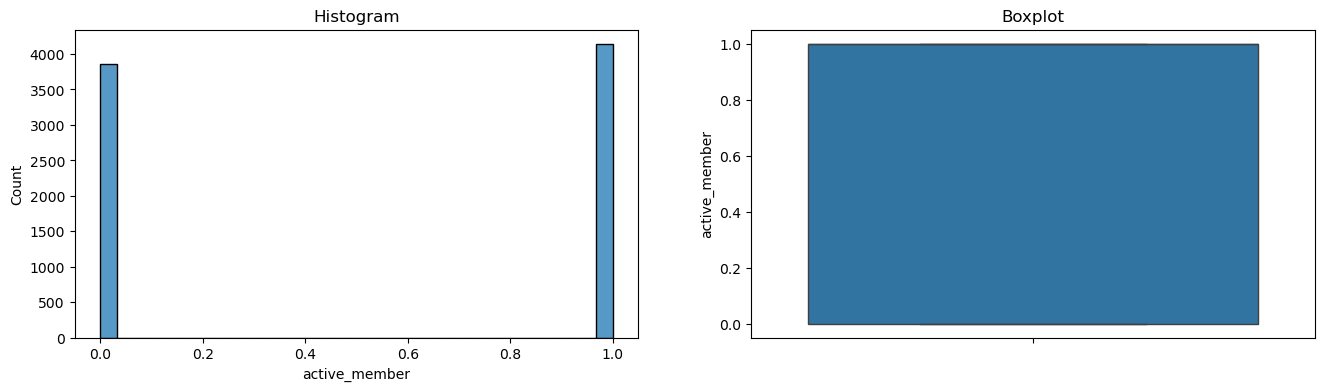


active_member - After Capping


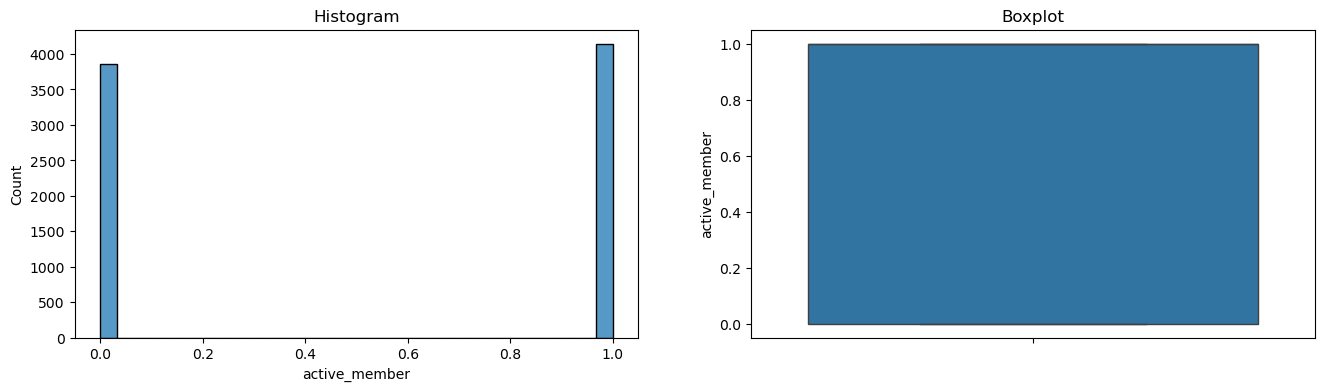

estimated_salary - Before Capping


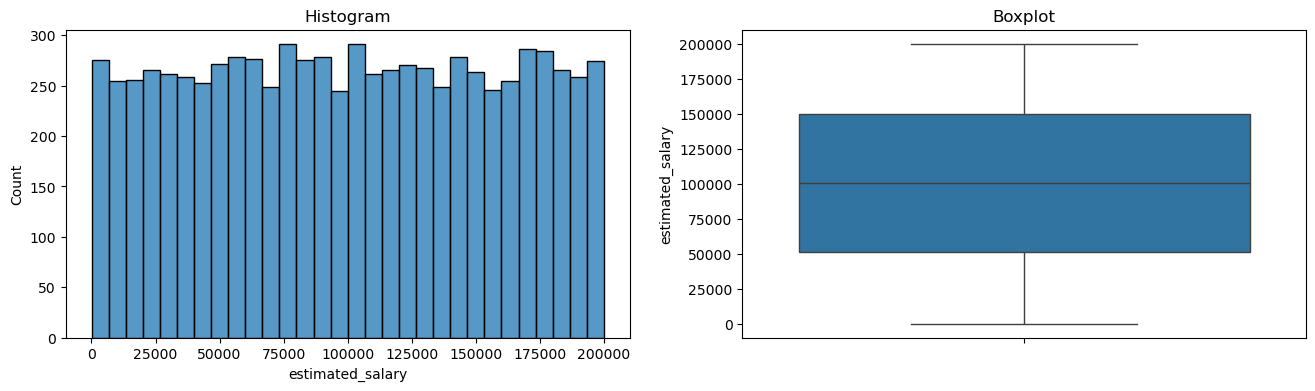


estimated_salary - After Capping


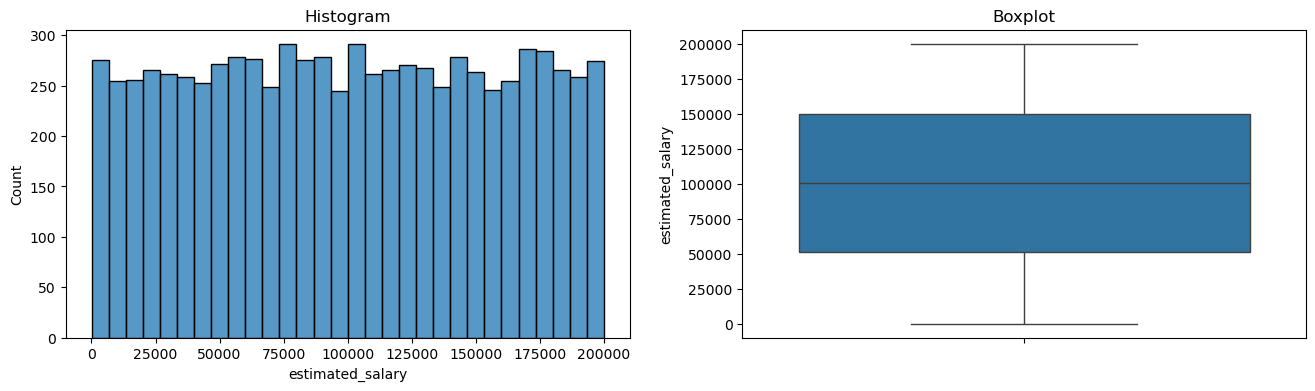

In [94]:
#looping sesuai kolom yang ada
for col in X_train:
    print(f'{col} - Before Capping')
    diagnostic_plots(X_train, col)

    print(f'\n{col} - After Capping')
    diagnostic_plots(X_train_capped, col)

Setelah melakukan proses outlier handling, dimana jika didapatkan data dari dataset yang digunakan telah bersih dari outlier. Sehingga sekarang kita bisa melakukan missing value handling.

- --

##### **Missing Value Handling**

Setelah melakukan outlier handling, langkah selanjutnya adalah mengecek apakah dataset memiliki missing value atau tidak. Jika dataset memiliki missing value, kita perlu mendrop missing value tersebut agar tidak mempengaruhi model klasifikasi kita.

In [95]:
#Mengetahui jumlah data yang memiliki nilai NaN
nan_churn_df = data_bank_customer_fe[data_bank_customer_fe['churn'].isna()]

# Group by country dan age serta menghitung jumlah missing value
nan_churn_grouped = nan_churn_df.groupby(['country', 'age']).size().reset_index(name='count')
nan_churn_grouped

,country,age,count


Berdasarkan pengecekan yang dilakukan, kita mendapatkan bahwa dataset yang digunakan tidak memiliki missing value sehingga kita dapat melanjutkan ke tahap berikutnya.

 - --

##### **Data Balancing**

Metode yang digunakan untuk melakukan data balancing adalah SMOTENC. Hal ini perlu dilakukan karena dataset ini memiliki jumlah value pada kolom target yang imbalance. Sehingga perlu dilakukan data balancing untuk mencegah hasil klasifikasi yang terlalu condong ke satu kelas daripada kelas yang lain sehingga hal ini mempengaruhi tingkat keakurasian model kita.

In [96]:
#Mengecek jumlah value pada kolom churn
churn_value = data_bank_customer_fe['churn'].value_counts()
churn_value

churn
0    7963
1    2037
Name: count, dtype: int64

Bisa dilihat bahwa data dengan value 0 atau kustomer loyal lebih banyak dari data dengan value 1 atau kustomer yang tidak loyal atau meninggalkan bank tersebut. Sehingga untuk mencegah hasil klasifikasi yang terlalu condong kepada kelas 0 maka data balancing akan dilakukan.

In [97]:
#Use SMOTENC to do the oversampling of the minority class.
sm = SMOTENC(random_state = 42, categorical_features=[2,3,5,7,8,9])
X_train_new, y_train_new = sm.fit_resample(X_train_capped, y_train)

In [98]:
print(Counter(y_train_new))
X_train_new.shape

Counter({0: 6372, 1: 6372})


(12744, 11)

Dengan melakukan proses SMOTENC, ukuran dataset yang sebelumnya adalah: 0=7963 dan 1=2037. Sekarang menjadi 0=6372 dan 1=6372 dengan ukuran dataset sekaran berubah menjadi 12744 rows x 11 columns.

- --

##### **Feature Selection**

Pada tahap ini, kita perlu melakukan uji korelasi dalam menentukan kolom-kolom mana saja yang akan digunakan untuk pemodelan klasifikasi, disini kita akan melihat hasil dari tau atau spearmanr statistic.

Disini nilai **alpha = 0.01**

**Kolom Kategorikal - Ordinal**

In [99]:
#Melakukan uji korelasi terhadap kolom ordinal

#Menentukan nilai alpha
alpha = 0.05

# Melakukan uji kendalltau pada kolom ordinal
correlation_df_categorical = pd.DataFrame(columns=['categorical_column', 'tau-statistic', 'p-value', 'is_correlated'])

for cat_column in ordinal_col:
    # Mengubah data kategori menjadi urutan angka
    cat_column_num = X_train_new[cat_column].astype('category').cat.codes
    y_train_num = y_train_new.astype('category').cat.codes
    
    tau, p = kendalltau(cat_column_num, y_train_num)
    
    is_correlated = 'Yes' if p < alpha else 'No'
    
    # Menggabungkan data dengan dataframe
    correlation_df_categorical = pd.concat([
        correlation_df_categorical,
        pd.DataFrame({'categorical_column': [cat_column], 'tau-statistic': [tau], 'p-value': [p], 'is_correlated': [is_correlated]})
    ], ignore_index=True)

# Menampilkan hasil uji korelasi pada kolom kategorikal - ordinal
correlation_df_categorical

/var/folders/pp/_scpqyy522j_3nxrlhdyg0wr0000gp/T/ipykernel_809/1949982609.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  correlation_df_categorical = pd.concat([


,categorical_column,tau-statistic,p-value,is_correlated
0,credit_card,-0.003116,7.250134e-01,No
1,active_member,-0.209805,5.287468e-124,Yes


Berdasarkan uji korelasi dengean menggunakan kendalltau terhadap kolom kategorikal - ordinal, kita mendapatkan bahwa kolom yang berkorelasi dengan customer churn adalah **`active_member`**.

**Kolom Kategorikal - Nominal**

In [100]:
#Melakukan uji korelasi terhadap kolom nominal

#Menentukan nilai alpha
alpha = 0.05

# Melakukan uji chi2 pada kolom nominal
correlation_df_categorical = pd.DataFrame(columns=['categorical_column', 'chi2-statistic', 'p-value', 'is_correlated'])

for cat_column in nominal_col:
    contingency_table = pd.crosstab(X_train_new[cat_column], y_train_new)
    chi2, p, _, _ = chi2_contingency(contingency_table)
    
    is_correlated = 'Yes' if p < alpha else 'No'
    
    # Melakukan concat pada data terhadap dataframe
    correlation_df_categorical = pd.concat([
        correlation_df_categorical,
        pd.DataFrame({'categorical_column': [cat_column], 'chi2-statistic': [chi2], 'p-value': [p], 'is_correlated': [is_correlated]})
    ], ignore_index=True)

# Menampilkan hasil uji korelasi chi2 terhadap kolom nominal
correlation_df_categorical

/var/folders/pp/_scpqyy522j_3nxrlhdyg0wr0000gp/T/ipykernel_809/1156714787.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  correlation_df_categorical = pd.concat([


,categorical_column,chi2-statistic,p-value,is_correlated
0,customer_id,12474.666667,6.039733e-01,No
1,country,653.433122,1.284696e-142,Yes
2,gender,200.574561,1.564771e-45,Yes
3,products_number,2436.812268,0.000000e+00,Yes


Sementara itu, berdasarkan uji korelasi yang dilakukan pada kolom kategorikal - nominal, kita mendapatkan bahwa kolom yang berkorelasi dengan customer churn adalah **`country`, `gender`, `products_number`**.

**Kolom Numerikal**

In [101]:
#Melakukan uji korelasi terhadap kolom nominal

#Menentukan nilai alpha
alpha = 0.05

# Melakukan uji korelasi terhadap kolom numerikal
correlation_df_num = pd.DataFrame(columns=['numerical column', 'correlation-statistic', 'p-value', 'is_correlated'])

for cont_column in numerikal_col:
    corr, p = spearmanr(X_train_new[cont_column], y_train_new)
    
    is_correlated = 'Yes' if p < alpha else 'No'
    
    # Menggabungkan data dengan dataframe
    correlation_df_num = pd.concat([
        correlation_df_num,
        pd.DataFrame({'numerical column': [cont_column], 'correlation-statistic': [corr], 'p-value': [p], 'is_correlated': [is_correlated]})
    ], ignore_index=True)

# Menampilkan hasil uji korelasi terhadap kolom numerikal
correlation_df_num

/var/folders/pp/_scpqyy522j_3nxrlhdyg0wr0000gp/T/ipykernel_809/2801566412.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  correlation_df_num = pd.concat([


,numerical column,correlation-statistic,p-value,is_correlated
0,credit_score,-0.051940,4.440146e-09,Yes
1,age,0.430951,0.000000e+00,Yes
2,tenure,-0.000579,9.479073e-01,No
3,balance,0.136695,3.326292e-54,Yes
4,estimated_salary,0.000767,9.309799e-01,No


Berdasarkan uji korelasi yang dilakukan terhadap kolom numerikal, didapatkan bahwa ada 3 kolom yang lolos uji korelasi dan akan digunakan untuk pemodelan klasifikasi yaitu: **`age`, `balance`**. Disini kolom `credit_score` tidak digunakan karena nilai korelasi yang dihasilkan diluar dari threshold yang didapatkan dari nilai alpha.

In [102]:
ordinal_cols = ['active_member']
nominal_cols = ['country','gender','products_number']
numerikal_cols = ['age','balance']

print(f'Kolom yang digunakan sebanyak: {len(ordinal_cols+nominal_cols+numerikal_cols)}')

Kolom yang digunakan sebanyak: 6


Sehingga dari 11 kolom yang tersedia di dataset, kita akan menggunakan 6 kolom saja dengan 5 di antaranya kita drop atau tidak digunakan. Dengan nama kolom yang digunakan di antaranya **`Active member`,`Country`,`Gender`,`Products number`,`Age`,`Balance`**.

- --

##### **Scaling dan Encoding**

Setelah melakukan proses feature selection dimana kita mendapatkan 6 kolom saja yang akan digunakan untuk pemodelan klasifikasi selanjutnya adalah melakukan proses scaling dan encoding dengan menggunakan pipeline untuk memudahkan pengerjaan serta menyimpan model.

Sebelum melakukan proses encoding dan scaling, kita perlu untuk mengecek skewness dari dataset, hal ini membantu kita dalam menentukan jenis scaler yang digunakan dimana standardscaler sangat sensitif dengan data skewness dan juga tidak memiliki distribusi yang normal.

In [103]:
def skew_checking(dataset):
    result = pd.DataFrame()
    col_name = []
    skew_score = []
    
    for column in dataset.columns:
        col_name.append(column)
    
    #Mencari nilai skewness
        skewval = dataset[column].skew()
        skew_score.append(skewval)
    result['Column'] = col_name
    result['Skew_score'] = skew_score

    return result

skew_check = skew_checking(numerikal_col)
skew_check

,Column,Skew_score
0,credit_score,-0.071607
1,age,1.011320
2,tenure,0.010991
3,balance,-0.141109
4,estimated_salary,0.002085


In [104]:
#Melakukan proses scaling dan encoding
num_pipeline = make_pipeline(MinMaxScaler())
num_pipeline.fit(X_train_new[numerikal_cols])
cat_pipeline = make_pipeline(OrdinalEncoder())
cat_pipeline.fit(X_train_new[ordinal_cols])
nom_pipeline = make_pipeline(OneHotEncoder(handle_unknown='ignore'))
nom_pipeline.fit(X_train_new[nominal_cols])

# ColumnTransformer
preprocessing_pipeline = ColumnTransformer([
    ('pipe_num', num_pipeline, numerikal_cols),
    ('pipe_cat', cat_pipeline, ordinal_cols),
    ('pipe_nom', nom_pipeline, nominal_cols)  # Use cat_pipeline here
])

In [105]:
# Transformasi data training
data_final_train = preprocessing_pipeline.fit_transform(X_train_new, y_train_new)

# Transformasi data testing yang sudah di handle outlier
data_final_test = preprocessing_pipeline.transform(X_test_capped)

#### **Model Definition**

Pada bagian ini, kita akan melakukan definisi model yang akan digunakan untuk melakukan klasifikasi yaitu di antaranya:
1. SVM
2. KNN
3. Decision Tree Classifier
4. Random Forest Classifier
5. Ada Boost Classifier
6. Gradient Boost Classifier

Masing-masing model ini menggunakan metode make_pipeline dengan tujuan untuk memudahkan proses column transformer serta menyimpan model dan juga melatih model serta evaluasi model. Hal ini dikarenakan kita hanya perlu untuk memanggil variabel yang menyimpan definisi model.

In [106]:
# Mendefinisikan masing-masing model yang akan digunakan
clfsvc = make_pipeline(preprocessing_pipeline, SVC())
clfknc = make_pipeline(preprocessing_pipeline, KNeighborsClassifier())
clfdec = make_pipeline(preprocessing_pipeline, DecisionTreeClassifier())
clfrfm = make_pipeline(preprocessing_pipeline, RandomForestClassifier())
clfada = make_pipeline(preprocessing_pipeline, AdaBoostClassifier())
clfgb = make_pipeline(preprocessing_pipeline, GradientBoostingClassifier())

clfsvc, clfknc, clfdec, clfrfm, clfada, clfgb

(Pipeline(steps=[('columntransformer',
                  ColumnTransformer(transformers=[('pipe_num',
                                                   Pipeline(steps=[('minmaxscaler',
                                                                    MinMaxScaler())]),
                                                   ['age', 'balance']),
                                                  ('pipe_cat',
                                                   Pipeline(steps=[('ordinalencoder',
                                                                    OrdinalEncoder())]),
                                                   ['active_member']),
                                                  ('pipe_nom',
                                                   Pipeline(steps=[('onehotencoder',
                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                   ['country', 'gender',
              

- --

#### **Model Training**

Pada bagian ini, model akan ditraining menggunakan metode StratifiedKFold Cross Validation. Pada kasus ini, K yang akan digunakan sebesar 6 dimana hal ini diambil berdasarkan dengan jumlah kolom yang akan dipakai untuk pemodelan. Alasan pemilihan **Stratified KFold Cross Validation** adalah metode ini dapat dilakukan untuk data yang imbalance sehingga dengan metode ini maka model dapat melatih model dengan ukuran data sampel yang sama dari setiap kelas.

Sementara scoring yang diambil akan berfokus pada precision hal ini dikarenakan bank ingin mengetahui seberapa pasti apakah seorang kustomer akan churn atau tidak. Dimana hal ini dilakukan untuk menghindari customer yang termasuk ke dalam False Positive yang dapat mengakibatkan bank mengeluarkan effort yang sia-sia dalam mempertahankan customer tersebut.

In [107]:
#Menentukan K yang akan digunakan
kfold_validation=StratifiedKFold(6)

In [108]:
# Mengecek hasil cross validation
cv_svm_model = cross_val_score(clfsvc, X_train_new, y_train_new, cv=kfold_validation, scoring="precision")
cv_dt_model = cross_val_score(clfdec, X_train_new, y_train_new, cv=kfold_validation, scoring="precision")
cv_rf_model = cross_val_score(clfrfm, X_train_new, y_train_new, cv=kfold_validation, scoring="precision")
cv_knn_model = cross_val_score(clfknc, X_train_new, y_train_new, cv=kfold_validation, scoring="precision")
cv_ada_model = cross_val_score(clfada, X_train_new, y_train_new, cv=kfold_validation, scoring="precision")
cv_gb_model = cross_val_score(clfgb, X_train_new, y_train_new, cv=kfold_validation, scoring="precision")
name_model = []
cv_scores=0
for cv,name in zip([cv_svm_model,cv_dt_model,cv_rf_model,cv_knn_model, cv_ada_model, cv_gb_model],['log_model','svm_model','dt_model','rf_model','knn_model','gradient_model','ada_model']):
    print(name)
    print('recall - All - Cross Validation  : ', cv)
    print('recall - Mean - Cross Validation : ', cv.mean())
    print('recall - Std - Cross Validation  : ', cv.std())
    print('recall - Range of Test-Set       : ', (cv.mean()-cv.std()) , '-', (cv.mean()+cv.std()))
    print('-'*50)
    if cv.mean()>cv_scores:
        cv_scores = cv.mean()
        name_model = name
    else:
        pass
print('best model:', name_model)
print('cross-val mean:', cv_scores)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/ana

log_model
recall - All - Cross Validation  :  [0.77228682 0.76814326 0.79599619 0.77861163 0.78482229 0.78655767]
recall - Mean - Cross Validation :  0.7810696438331548
recall - Std - Cross Validation  :  0.009285056564357028
recall - Range of Test-Set       :  0.7717845872687977 - 0.7903547003975119
--------------------------------------------------
svm_model
recall - All - Cross Validation  :  [0.77574591 0.75191571 0.791423   0.76459854 0.77681992 0.78125   ]
recall - Mean - Cross Validation :  0.773625513967934
recall - Std - Cross Validation  :  0.012532528281446007
recall - Range of Test-Set       :  0.761092985686488 - 0.78615804224938
--------------------------------------------------
dt_model
recall - All - Cross Validation  :  [0.79001883 0.79293893 0.81088825 0.77649154 0.81835938 0.79839429]
recall - Mean - Cross Validation :  0.7978485370277782
recall - Std - Cross Validation  :  0.013738973124258775
recall - Range of Test-Set       :  0.7841095639035195 - 0.81158751015203

Berdasarkan hasil training model yang dihasilkan oleh KFold Cross Validation, kita mendapatkan bahwa model terbaik adalah Gradient Boost Classifier dengan nilai precision sebesar **80.61%**.

#### **Hyperparameter Tuning**

Berdasarkan hasil dari model training yang didapatkan sebelumnya, kita mendapatkan bahwa hasil model terbaik berdasarkan dengan scoring terhadap precision adalah **Decision Tree Classifier** dengan hasil presisi sebesar **68.6%**.

Setelah mendapatkan informasi tersebut, selanjutnya kita perlu untuk melakukan hyperparameter tuning dengan tujuan agar model mendapatkan hasil presisi terbaik dan juga menghindari hasil yang terlalu overfitting atau mendapatkan hasil presisi yang terlalu rendah.

In [109]:
#melakukan cek hyperparameter untuk gradient boosting classifier
param_grid = {
    'gradientboostingclassifier__n_estimators': [10,50,100],
    'gradientboostingclassifier__learning_rate': [0.01,0.05,0.1,0.2],
    'gradientboostingclassifier__max_depth': np.arange(2, 11, 3).tolist()
}
grid_gb = RandomizedSearchCV(clfgb, param_distributions=param_grid, cv=10, n_iter=60, random_state=84, n_jobs=-1, scoring='precision')
grid_gb.fit(X_train_new, y_train_new)

print('Best cross-validation accuracy : {:.2f}'.format(grid_gb.best_score_))
print('Best parameters : ', grid_gb.best_params_)
print('Test set accuracy : {:.2f}'.format(grid_gb.score(X_test_capped, y_test)))

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 36 is smaller than n_iter=60. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best cross-validation accuracy : 0.81
Best parameters :  {'gradientboostingclassifier__n_estimators': 100, 'gradientboostingclassifier__max_depth': 5, 'gradientboostingclassifier__learning_rate': 0.1}
Test set accuracy : 0.50


In [110]:
#Menampilkan model terbaik dari gradient boosting
gridgbmest = grid_gb.best_estimator_
gridgbmest

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipe_num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'balance']),
                                                 ('pipe_cat',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder())]),
                                                  ['active_member']),
                                                 ('pipe_nom',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['country', 'gender',
                                                   'products_number'])])),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(max_depth=5))])

Disini kita mendapatkan hasil hyperparameter tuning terbaik dari GradientBoosting Classifier adalah:
1. Learning Rate = 0.2
2. Max depth = 5
3. n estimator = 50

Setelah mendapatkan hasil tuning terbaik selanjutnya disimpan pada model saving serta digunakan pada model evaluation.

- --

#### **Model Evaluation**

Disini model evaluation menggunakan pipeline, hal ini dikarenakan untuk memudahkan proses evaluasi data atau pada bagian ini adalah untuk melakukan model fit, dimana pada bagian sebelumnya model belum difit dengan data training.

In [111]:
# Mendefinisikan pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessing_pipeline),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Melakukan fit pada data training
pipeline.fit(X_train_new, y_train_new)

# Membuat prediksi dataset
y_pred_train = pipeline.predict(X_train_new)
y_pred_test = pipeline.predict(X_test_capped)

# Evaluasi hasil training model
print('Train')
print(classification_report(y_train_new, y_pred_train))
print('')

print('Test')
print(classification_report(y_test, y_pred_test))

Train
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      6372
           1       0.97      0.97      0.97      6372

    accuracy                           0.97     12744
   macro avg       0.97      0.97      0.97     12744
weighted avg       0.97      0.97      0.97     12744


Test
              precision    recall  f1-score   support

           0       0.91      0.78      0.84      1591
           1       0.45      0.69      0.54       409

    accuracy                           0.76      2000
   macro avg       0.68      0.74      0.69      2000
weighted avg       0.81      0.76      0.78      2000



Sesudah Hyperparameter Tuning

Training Accuracy After Hyperparameter Tuning: 0.84
Train
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      6372
           1       0.84      0.84      0.84      6372

    accuracy                           0.84     12744
   macro avg       0.84      0.84      0.84     12744
weighted avg       0.84      0.84      0.84     12744


Testing Accuracy After Hyperparameter Tuning: 0.80
Test
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      1591
           1       0.50      0.72      0.59       409

    accuracy                           0.80      2000
   macro avg       0.71      0.77      0.73      2000
weighted avg       0.83      0.80      0.81      2000




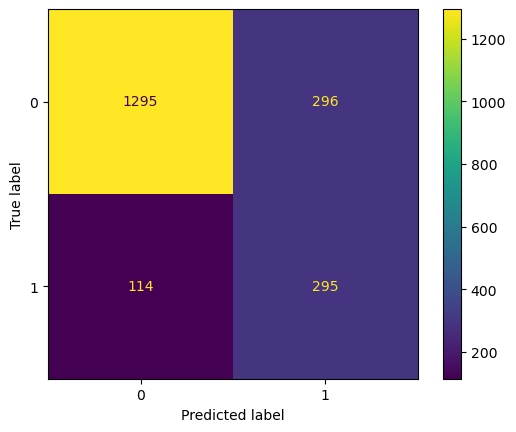

In [112]:
# Mengecek performa model
print('Sesudah Hyperparameter Tuning')
print('')

# Hasil akurasi dan prediksi model training
y_pred_train_predict_tuned = grid_gb.best_estimator_.predict(X_train_new)
training_accuracy_tuned = grid_gb.best_estimator_.score(X_train_new, y_train_new)
print('Training Accuracy After Hyperparameter Tuning: {:.2f}'.format(training_accuracy_tuned))
print('Train')
print(classification_report(y_train_new, y_pred_train_predict_tuned))
print('')

# Hasil akurasi dan prediksi model testing
y_pred_test_predict_tuned = grid_gb.best_estimator_.predict(X_test_capped)
testing_accuracy_tuned = grid_gb.best_estimator_.score(X_test_capped, y_test)
print('Testing Accuracy After Hyperparameter Tuning: {:.2f}'.format(testing_accuracy_tuned))
print('Test')
print(classification_report(y_test, y_pred_test_predict_tuned))
print('')

# Menampilkan confusion matrix
cm = confusion_matrix(y_test, y_pred_test_predict_tuned)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_gb.best_estimator_.classes_)
disp.plot()
plt.show()


Menurut hasil evaluasi yang didapatkan antara sebelum dan sesudah dilakukan hyperparameter tuning kita mendapatkan bahwa hasil training pada precision yang didapatkan pada kelas 0 mencapai angka 84% untuk training dan 91% untuk test setelah hyperparameter tuning, sementara hasil kebalikan didapatkan pada kelas 1 dimana hasil training menyentuh 84% dan 49% untuk test dikarenakan jumlah dataset yang tidak balance pada data test sehingga menyebabkan model overfitting.

Selain itu menurut confusion matrix kita mendapatkan hasil:
| Metrics | Hasil |
| ----- | ----- |
| True Positive | 1295 |
| False Positive | 296 |
| False Negative | 114 |
| True Negative | 295 |

- --

#### **Model Saving**

Setelah melakukan model training dan model evaluation, hasil terbaik dapat disimpan ke dalam model saving beserta dengan nama kolom dan lain-kain untuk melakukan proses model inference serta model deployment.

In [113]:
#Menyimpan model
with open('list_num_cols.txt', 'w') as file_1:
  json.dump(numerikal_colname, file_1)

with open('list_ordinal_cols.txt', 'w') as file_2:
  json.dump(ordinal_colname, file_2)

with open('list_ordinal_cols.txt', 'w') as file_3:
  json.dump(nominal_colname, file_3)

with open('best_models_gb.pkl', 'wb') as file_4:
  pickle.dump(gridgbmest, file_4)

with open('scaler.pkl', 'wb') as file_5:
  pickle.dump(num_pipeline, file_5)

with open('encoderord.pkl', 'wb') as file_6:
  pickle.dump(cat_pipeline, file_6)

with open('encoderord.pkl', 'wb') as file_7:
  pickle.dump(nom_pipeline, file_7)


- --

#### **Kesimpulan**

Menurut pengamatan yang telah dilakukan, kita mendapatkan bahwa Prancis merupakan negara dengan jumlah customer churn paling banyak diikuti oleh Spanyol dan terakhir Jerman. Hal ini bisa diasumsikan bahwa bank cukup populer di kalangan masyarakat di negara Prancis sehingga bank perlu memperbaiki strategi marketing mereka dengan meningkatkan pelayanan mereka, meningkatkan penawaran yang menguntungkan kepada customer seperti bunga 0% atau pemberian merit poin untuk ditukarkan sehingga menarik pelanggan lebih banyak.

Selain itu, jika dilihat berdasarkan products number maka products number 1 dan 2 paling banyak digunakan sehingga hal ini harus tetap dipertahankan, namun bank perlu meningkatkan kualitas dari products number 3 dan 4 dimana products number ini paling jarang digunakan di negara Prancis, Spanyol, dan Jerman. Hal ini dapat diasumsikan terjadi karena kedua products number tersebut kurang memberikan benefit kepada customer dalam kegiatan sehari-hari.

Oleh karena itu bank perlu meningkatkan penawaran mereka pada kedua products ini seperti memberikan poin untuk setiap penggunaan products number 3 dan 4 yang bisa ditukarkan atau merubah pendekatan mereka kepada customer terkait kedua produk ini.

- --

Selain itu, berdasarkan model training dan model evaluasi yang dilakukan baik sebelum dan sesudah dilakukan hyperparameter tuning didapatkan bahwa skor presisi yang didapatkan cenderung menurun untuk data training dimana:

| Kelas | Presisi Skor Training Base | Presisi Skor Testing Base | Presisi Skor Training Hyperparameter Tuning | Presisi Skor Testing Hyperparameter Tuning |
|-------|----------------------------|---------------------------|--------------------------------------------|--------------------------------------------|
| 0     | 97%               | 91%              | 84%                               | 92%                               |
| 1     | 97%               | 45%              | 84%                               | 50%                               |

Jika diperhatikan, presisi skor yang didapatkan pada kelas 0 cenderung menurun, tetapi hasil yang didapatkan menunjukkan kebalikan dimana pada model based presisi menunjukkan overfitting tetapi setelah dilakukan hyperparameter tuning model menjadi lebih baik.

Tetapi jika dilihat pada presisi skor testing pada kelas 1, model tetap overfitting hal ini dikarenakan jumlah model yang imbalance menyebabkan model kurang dapat mengklasifikasikan data dengan kelas 1.


- --

#### **Conceptual Problem**

**1. Jelaskan latar belakang adanya bagging dan cara kerja bagging !**

Bagging atau bootstrap aggergation adalah sebuah metode ensemble learning yang pada umumnya digunakan untuk mengurangi variansi data pada dataset yang noisy. Dimana random sample dari data pada data training dipilih secara bergantian sehingga setiap titik data dapat dipilih lebih dari satu kali.

Terdapat 3 metode cara kerja bagging:
1. Bootstrapping: bagging meningkatkan teknik sampling bootstrap agar data yang dihasilkan lebih bervariasi.
2. Parallel training: sample dari bootstrap dilatih secara independen dan dalam kondisi paralel satu sama lain dengan model base.
3. Agregasi: Rata-rata atau sebagian data diambil untuk menghitung hasil akurasi yang lebih akurat tetapi hal ini bergantung pada model yang dikerjakan apakah klasifikai atau regresi.

- --

**2. Jelaskan perbedaan cara kerja algoritma Random Forest dengan algoritma gradient boosting!**

Disini terdapat dua algoritma boosting yang digunakan yaitu Adaboost dan gradient boosting tetapi disini saya membandingkan random forest dengan gradient boosting sebagai model boosting dengan hasil paling baik.

Perbedaan paling mendasar dari cara kerja ini adalah bagaimana model melakukan proses training di antara keduanya. Dimana pada proses random forest, setiap tree dari model ini bersifat independen sehingga mereka dapat menentukan output dalam urutan atau sequence apapun yang kemudian digabungkan menjadi prediksi kolektif. Sementara pada algoritma gradient boosting, model training dilakukan secara bertahap dan urutan tersebut tidak dapat diubah.

- --

**3. Jelaskan apa yang dimaksud dengan Cross Validation !**

Cross Validation adalah teknik yang dilakukan untuk mengevaluasi performa dari model Machine Learning dengan melatih beberapa model pada subset data yang menjadi input yang kemudian dilakukan evaluasi pada subset data tersebut.

- --